In [1]:
#@title Installation and Imports

# !pip install -qq pyro-ppl

from typing import Optional, Tuple, Type, Union

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pyro
import pyro.distributions as dist
import pyro.infer as infer
import pyro.optim as optim
import torch
import torch.nn as nn
from scipy.stats import norm
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import warnings
warnings.filterwarnings("ignore", module="torchvision.datasets")

/home/gridsan/ggupta/.conda/envs/my_env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from src.rvae import *
from src.models import *
from src.functions import *
from src.trainer import *
from src.data import *
from src.classifier import *

In [3]:
def get_mnist_data(dataset, digits, n_samples, rotation_range, rotate) -> Tuple[torch.Tensor]:
    # !wget www.di.ens.fr/~lelarge/MNIST.tar.gz
    # !tar -zxvf MNIST.tar.gz
    data, labels, angles = [], [], []
    count = torch.zeros(10)
    for i, (im, lbl) in enumerate(dataset):
        if lbl in digits:
            if n_samples is None:
                theta = torch.randint(*rotation_range, (1,)).float()
                if rotate:
                    im = im.rotate(theta.item(), resample=Image.BICUBIC)
                data.append(ToTensor()(im))
                labels.append(lbl)
                angles.append(torch.deg2rad(theta))
            elif count[lbl]<n_samples:
                theta = torch.randint(*rotation_range, (1,)).float()
                if rotate:
                    im = im.rotate(theta.item(), resample=Image.BICUBIC)
                data.append(ToTensor()(im))
                labels.append(lbl)
                angles.append(torch.deg2rad(theta))
                count[lbl] = count[lbl]+1
    return torch.cat(data), torch.tensor(labels), torch.tensor(angles)

In [4]:
mnist_trainset = datasets.MNIST('data/mnist/', train=True, download=True)
mnist_testset = datasets.MNIST('data/mnist/', train=False, download=True)
train_data, train_labels, train_angles = get_mnist_data(mnist_trainset, digits = [0], n_samples = None, rotation_range=[-60, 61], rotate = True)
train_loader = init_dataloader(train_data, batch_size=200)

/state/partition1/slurm_tmp/21252768.0.0/ipykernel_26197/3643694743.py:11: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  im = im.rotate(theta.item(), resample=Image.BICUBIC)


In [5]:
torch.cuda.is_available()

False

In [6]:
torch.cuda.device_count()

0

In [7]:
def train_rvae(path, labels):
    train_data, train_labels, train_angles = get_mnist_data(mnist_trainset, digits = labels, n_samples = None, rotation_range=[-60, 61], rotate = True)
    train_loader = init_dataloader(train_data, batch_size=100)

    in_dim = (28, 28)
    # # Initialize probabilistic VAE model ->
    # # (coord=0: vanilla VAE
    # #  coord=1: rotations only
    # #  coord=2: translations only
    # #  coord=3: rotations+translations)
    rvae = rVAE(in_dim, latent_dim=10, coord=1, seed=0)

    # # # Initialize SVI trainer
    trainer = SVItrainer(rvae)
    # Train for n epochs:ccc
    for e in range(100):
        # Scale factor balances the qualitiy of reconstruction with the quality of disentanglement
        # It is optional, and the rvae will also work without it
        trainer.step(train_loader, scale_factor=3)
        trainer.print_statistics()
    trainer.save_model(rvae, path)
#     trainer.load_model(rvae, path)

In [ ]:
%%capture cap_f1
train_rvae('saved_models/rvae_rotation_z_100_label_0.pkl', [0])
train_rvae('saved_models/rvae_rotation_z_100_label_01.pkl', [0, 1])
train_rvae('saved_models/rvae_rotation_z_100_label_012.pkl', [0, 1, 2])
train_rvae('saved_models/rvae_rotation_z_100_label_0123.pkl', [0, 1, 2, 3])
train_rvae('saved_models/rvae_rotation_z_100_label_01234.pkl', [0, 1, 2, 3, 4])
train_rvae('saved_models/rvae_rotation_z_100_label_012345.pkl', [0, 1, 2, 3, 4, 5])
train_rvae('saved_models/rvae_rotation_z_100_label_0123456.pkl', [0, 1, 2, 3, 4, 5, 6])
train_rvae('saved_models/rvae_rotation_z_100_label_01234567.pkl', [0, 1, 2, 3, 4, 5, 6, 7])
train_rvae('saved_models/rvae_rotation_z_100_label_012345678.pkl', [0, 1, 2, 3, 4, 5, 6, 7, 8])
train_rvae('saved_models/rvae_rotation_z_100_label_0123456789.pkl', [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

%%capture cap_f1
train_rvae('saved_models/rvae_rotation_z_10_label_0.pkl', [0])
train_rvae('saved_models/rvae_rotation_z_10_label_01.pkl', [0, 1])
train_rvae('saved_models/rvae_rotation_z_10_label_012.pkl', [0, 1, 2])
train_rvae('saved_models/rvae_rotation_z_10_label_0123.pkl', [0, 1, 2, 3])
train_rvae('saved_models/rvae_rotation_z_10_label_01234.pkl', [0, 1, 2, 3, 4])
train_rvae('saved_models/rvae_rotation_z_10_label_012345.pkl', [0, 1, 2, 3, 4, 5])
train_rvae('saved_models/rvae_rotation_z_10_label_0123456.pkl', [0, 1, 2, 3, 4, 5, 6])
train_rvae('saved_models/rvae_rotation_z_10_label_01234567.pkl', [0, 1, 2, 3, 4, 5, 6, 7])
train_rvae('saved_models/rvae_rotation_z_10_label_012345678.pkl', [0, 1, 2, 3, 4, 5, 6, 7, 8])
train_rvae('saved_models/rvae_rotation_z_10_label_0123456789.pkl', [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [8]:
def train_vae(path, labels):
    train_data, train_labels, train_angles = get_mnist_data(mnist_trainset, digits = labels, n_samples = None, rotation_range=[-60, 61], rotate = True)
    train_loader = init_dataloader(train_data, batch_size=100)

    in_dim = (28, 28)
    # # Initialize probabilistic VAE model ->
    # # (coord=0: vanilla VAE
    # #  coord=1: rotations only
    # #  coord=2: translations only
    # #  coord=3: rotations+translations)
    vae = rVAE(in_dim, latent_dim=100, coord=0, seed=0)

    # # # Initialize SVI trainer
    trainer = SVItrainer(rvae)
    # Train for n epochs:ccc
    for e in range(100):
        # Scale factor balances the qualitiy of reconstruction with the quality of disentanglement
        # It is optional, and the rvae will also work without it
        trainer.step(train_loader, scale_factor=3)
        trainer.print_statistics()
    trainer.save_model(vae, path)

In [ ]:
%%capture cap_f1
train_vae('saved_models/vae_rotation_z_100_label_0.pkl', [0])
train_vae('saved_models/vae_rotation_z_100_label_01.pkl', [0, 1])
train_vae('saved_models/vae_rotation_z_100_label_012.pkl', [0, 1, 2])
train_vae('saved_models/vae_rotation_z_100_label_0123.pkl', [0, 1, 2, 3])
train_vae('saved_models/vae_rotation_z_100_label_01234.pkl', [0, 1, 2, 3, 4])
train_vae('saved_models/vae_rotation_z_100_label_012345.pkl', [0, 1, 2, 3, 4, 5])
train_vae('saved_models/vae_rotation_z_100_label_0123456.pkl', [0, 1, 2, 3, 4, 5, 6])
train_vae('saved_models/vae_rotation_z_100_label_01234567.pkl', [0, 1, 2, 3, 4, 5, 6, 7])
train_vae('saved_models/vae_rotation_z_100_label_012345678.pkl', [0, 1, 2, 3, 4, 5, 6, 7, 8])
train_vae('saved_models/vae_rotation_z_100_label_0123456789.pkl', [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

train_vae('saved_models/vae_rotation_z_10_label_0.pkl', [0])
train_vae('saved_models/vae_rotation_z_10_label_01.pkl', [0, 1])
train_vae('saved_models/vae_rotation_z_10_label_012.pkl', [0, 1, 2])
train_vae('saved_models/vae_rotation_z_10_label_0123.pkl', [0, 1, 2, 3])
train_vae('saved_models/vae_rotation_z_10_label_01234.pkl', [0, 1, 2, 3, 4])
train_vae('saved_models/vae_rotation_z_10_label_012345.pkl', [0, 1, 2, 3, 4, 5])
train_vae('saved_models/vae_rotation_z_10_label_0123456.pkl', [0, 1, 2, 3, 4, 5, 6])
train_vae('saved_models/vae_rotation_z_10_label_01234567.pkl', [0, 1, 2, 3, 4, 5, 6, 7])
train_vae('saved_models/vae_rotation_z_10_label_012345678.pkl', [0, 1, 2, 3, 4, 5, 6, 7, 8])
train_vae('saved_models/vae_rotation_z_10_label_0123456789.pkl', [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

# Classifier

In [9]:
train_data, train_labels, train_angles= get_mnist_data(mnist_testset, digits = [0,1,2,3,4], n_samples = None, rotation_range=[-60, 61], rotate = False)
test_data, test_labels, test_angles = get_mnist_data(mnist_testset, digits = [0,1,2,3,4], n_samples = None, rotation_range=[-60, 61], rotate = True)
mnist_trainclassifier = [[train_data[i], train_labels[i]] for i in range(len(train_data))]
mnist_testclassifier = [[test_data[i], test_labels[i]] for i in range(len(test_data))]

In [10]:
import pickle
model = MLP()
model.to(device)
mlp_mnist_results = train_nn(model, rvae, mnist_trainclassifier, mnist_testclassifier, num_epochs = 10)
# with open('saved_models/dict_rvae_rotated_mnist_half_classifier.pkl', 'wb') as handle:
#     pickle.dump(mlp_mnist_results, handle, protocol=pickle.HIGHEST_PROTOCOL)
# torch.save(model.state_dict(), 'saved_models/dict_rvae_rotated_mnist_half_classifier.pkl')    
# with open('saved_models/dict_rvae_rotated_mnist_half_classifier.pkl', 'rb') as handle:
#     results = pickle.load(handle)
# model.load_state_dict(torch.load('saved_models/dict_rvae_rotated_mnist_half_classifier.pkl'))

100%|████████████████████████████████████████| 161/161 [00:01<00:00, 160.81it/s]


Epoch 0: Train Loss=2.1807693961244192 Train Acc=41.00400457665904 Validation Acc=59.48328702190258%


100%|████████████████████████████████████████| 161/161 [00:00<00:00, 231.09it/s]


Epoch 1: Train Loss=1.8892044191775115 Train Acc=80.09766263484799 Validation Acc=88.42452598888525%


100%|████████████████████████████████████████| 161/161 [00:00<00:00, 231.98it/s]


Epoch 2: Train Loss=1.6637703395037917 Train Acc=91.16745668519124 Validation Acc=91.42080745341616%


100%|████████████████████████████████████████| 161/161 [00:00<00:00, 187.38it/s]


Epoch 3: Train Loss=1.5933066465839836 Train Acc=93.14727034978752 Validation Acc=92.41071428571429%


100%|████████████████████████████████████████| 161/161 [00:00<00:00, 235.35it/s]


Epoch 4: Train Loss=1.567751959984347 Train Acc=93.62025988885256 Validation Acc=93.01242236024845%


100%|████████████████████████████████████████| 161/161 [00:01<00:00, 130.13it/s]


Epoch 5: Train Loss=1.5512996882385348 Train Acc=94.37724746649232 Validation Acc=92.64976299444263%


100%|████████████████████████████████████████| 161/161 [00:00<00:00, 211.24it/s]


Epoch 6: Train Loss=1.5440542957057124 Train Acc=94.29347826086956 Validation Acc=93.47826086956522%


100%|████████████████████████████████████████| 161/161 [00:01<00:00, 109.08it/s]


Epoch 7: Train Loss=1.5387773995073686 Train Acc=94.53865642366786 Validation Acc=92.84386237332461%


100%|████████████████████████████████████████| 161/161 [00:00<00:00, 205.06it/s]


Epoch 8: Train Loss=1.5336057562265337 Train Acc=94.6878064727035 Validation Acc=92.93478260869566%


100%|████████████████████████████████████████| 161/161 [00:00<00:00, 231.75it/s]


Epoch 9: Train Loss=1.5289127530518525 Train Acc=94.84921542987904 Validation Acc=93.52321019941157%


In [11]:
train_data, train_labels, train_angles= get_mnist_data(mnist_testset, digits = [5,6,7,8,9], n_samples = None, rotation_range=[-60, 61], rotate = False)
test_data, test_labels, test_angles = get_mnist_data(mnist_testset, digits = [5,6,7,8,9], n_samples = None, rotation_range=[-60, 61], rotate = True)
mnist_trainclassifier = [[train_data[i], train_labels[i]] for i in range(len(train_data))]
mnist_testclassifier = [[test_data[i], test_labels[i]] for i in range(len(test_data))]

In [13]:
import pickle
model = MLP()
model.to(device)
mlp_mnist_results = train_nn(model, rvae, mnist_trainclassifier, mnist_testclassifier, num_epochs = 100)
# with open('saved_models/dict_rvae_rotated_mnist_other_half_classifier.pkl', 'wb') as handle:
#     pickle.dump(mlp_mnist_results, handle, protocol=pickle.HIGHEST_PROTOCOL)
# torch.save(model.state_dict(), 'saved_models/rvae_rotated_mnist_other_half_classifier.pkl')    
# with open('saved_models/dict_rvae_rotated_mnist_other_half_classifier.pkl', 'rb') as handle:
#     results = pickle.load(handle)
# model.load_state_dict(torch.load('saved_models/rvae_rotated_mnist_other_half_classifier.pkl'))

with open('saved_models/dict_rvae_rotated_mnist_other_half_classifier_z_100.pkl', 'wb') as handle:
    pickle.dump(mlp_mnist_results, handle, protocol=pickle.HIGHEST_PROTOCOL)
torch.save(model.state_dict(), 'saved_models/rvae_rotated_mnist_other_half_classifier_z_100.pkl')    
with open('saved_models/dict_rvae_rotated_mnist_other_half_classifier_z_100.pkl', 'rb') as handle:
    results = pickle.load(handle)
model.load_state_dict(torch.load('saved_models/rvae_rotated_mnist_other_half_classifier_z_100.pkl'))

100%|████████████████████████████████████████| 152/152 [00:00<00:00, 198.58it/s]


Epoch 0: Train Loss=2.195136984712199 Train Acc=32.776344147005446 Validation Acc=45.391901088929224%


100%|████████████████████████████████████████| 152/152 [00:00<00:00, 264.55it/s]


Epoch 1: Train Loss=2.019382071338202 Train Acc=53.138469827586206 Validation Acc=54.63716538112523%


100%|████████████████████████████████████████| 152/152 [00:01<00:00, 135.93it/s]


Epoch 2: Train Loss=1.913861746066495 Train Acc=60.548292876588015 Validation Acc=60.932537431941924%


100%|████████████████████████████████████████| 152/152 [00:00<00:00, 230.44it/s]


Epoch 3: Train Loss=1.8529500475055294 Train Acc=65.94118647912886 Validation Acc=63.566243194192374%


100%|████████████████████████████████████████| 152/152 [00:00<00:00, 234.52it/s]


Epoch 4: Train Loss=1.8229001674212908 Train Acc=67.61853448275863 Validation Acc=65.0259471415608%


100%|████████████████████████████████████████| 152/152 [00:00<00:00, 233.01it/s]


Epoch 5: Train Loss=1.807016101322676 Train Acc=68.11408235027223 Validation Acc=65.1493024047187%


100%|████████████████████████████████████████| 152/152 [00:01<00:00, 117.33it/s]


Epoch 6: Train Loss=1.796804049297383 Train Acc=68.7308586660617 Validation Acc=65.27265766787659%


100%|████████████████████████████████████████| 152/152 [00:00<00:00, 201.78it/s]


Epoch 7: Train Loss=1.7941333784868843 Train Acc=68.05027790381125 Validation Acc=65.60160503629764%


100%|████████████████████████████████████████| 152/152 [00:00<00:00, 231.10it/s]


Epoch 8: Train Loss=1.7834062333169736 Train Acc=69.33132940108892 Validation Acc=66.31692377495463%


100%|████████████████████████████████████████| 152/152 [00:01<00:00, 118.24it/s]


Epoch 9: Train Loss=1.7870841418441974 Train Acc=69.04775408348458 Validation Acc=65.5399274047187%


100%|████████████████████████████████████████| 152/152 [00:00<00:00, 198.02it/s]


Epoch 10: Train Loss=1.7698179420671964 Train Acc=70.2543670598911 Validation Acc=65.59735140653358%


100%|████████████████████████████████████████| 152/152 [00:00<00:00, 228.95it/s]


Epoch 11: Train Loss=1.7803762555122375 Train Acc=68.60537658802178 Validation Acc=65.62003743194192%


100%|████████████████████████████████████████| 152/152 [00:01<00:00, 108.72it/s]


Epoch 12: Train Loss=1.7741397336909646 Train Acc=69.67870916515426 Validation Acc=66.46083824863884%


100%|████████████████████████████████████████| 152/152 [00:00<00:00, 206.53it/s]


Epoch 13: Train Loss=1.7743936432035345 Train Acc=69.00025521778585 Validation Acc=65.7228334845735%


100%|████████████████████████████████████████| 152/152 [00:00<00:00, 215.38it/s]


Epoch 14: Train Loss=1.771361231803894 Train Acc=69.90698729582577 Validation Acc=65.83768148820327%


100%|████████████████████████████████████████| 152/152 [00:01<00:00, 111.58it/s]


Epoch 15: Train Loss=1.7731232572542994 Train Acc=69.42987182395645 Validation Acc=66.36654945553539%


100%|████████████████████████████████████████| 152/152 [00:00<00:00, 200.22it/s]


Epoch 16: Train Loss=1.773539999597951 Train Acc=69.68650748638838 Validation Acc=66.33960980036298%


100%|████████████████████████████████████████| 152/152 [00:00<00:00, 230.12it/s]


Epoch 17: Train Loss=1.7596408583615955 Train Acc=71.1915834845735 Validation Acc=65.33433529945553%


100%|████████████████████████████████████████| 152/152 [00:01<00:00, 106.57it/s]


Epoch 18: Train Loss=1.767377462826277 Train Acc=69.87366719600726 Validation Acc=66.03760208711434%


100%|████████████████████████████████████████| 152/152 [00:00<00:00, 207.43it/s]


Epoch 19: Train Loss=1.7657772137930519 Train Acc=69.96653811252268 Validation Acc=66.09715290381125%


100%|████████████████████████████████████████| 152/152 [00:00<00:00, 225.56it/s]


Epoch 20: Train Loss=1.7663146390726692 Train Acc=70.05728221415607 Validation Acc=65.2932168784029%


100%|████████████████████████████████████████| 152/152 [00:01<00:00, 109.45it/s]


Epoch 21: Train Loss=1.7624137558435138 Train Acc=70.50107758620689 Validation Acc=66.34599024500908%


100%|████████████████████████████████████████| 152/152 [00:00<00:00, 205.44it/s]


Epoch 22: Train Loss=1.7615775207155628 Train Acc=70.28130671506352 Validation Acc=65.97379764065336%


100%|████████████████████████████████████████| 152/152 [00:00<00:00, 224.19it/s]


Epoch 23: Train Loss=1.7586241591917842 Train Acc=70.6116719600726 Validation Acc=65.58529945553539%


100%|████████████████████████████████████████| 152/152 [00:01<00:00, 142.14it/s]


Epoch 24: Train Loss=1.7682067046039982 Train Acc=69.55322708711434 Validation Acc=65.70014745916515%


100%|████████████████████████████████████████| 152/152 [00:00<00:00, 207.54it/s]


Epoch 25: Train Loss=1.760278875890531 Train Acc=70.05302858439201 Validation Acc=65.66328266787659%


100%|████████████████████████████████████████| 152/152 [00:00<00:00, 224.85it/s]


Epoch 26: Train Loss=1.7624031736662513 Train Acc=70.52943511796734 Validation Acc=65.72496029945553%


100%|████████████████████████████████████████| 152/152 [00:00<00:00, 221.45it/s]


Epoch 27: Train Loss=1.7648635883080332 Train Acc=70.06933416515426 Validation Acc=66.2431941923775%


100%|████████████████████████████████████████| 152/152 [00:00<00:00, 208.14it/s]


Epoch 28: Train Loss=1.7606586947252876 Train Acc=69.98497050816697 Validation Acc=66.53527676950999%


100%|████████████████████████████████████████| 152/152 [00:00<00:00, 228.40it/s]


Epoch 29: Train Loss=1.760985824622606 Train Acc=70.58756805807622 Validation Acc=66.01066243194192%


100%|████████████████████████████████████████| 152/152 [00:00<00:00, 227.68it/s]


Epoch 30: Train Loss=1.76235090352987 Train Acc=69.88217445553539 Validation Acc=65.7228334845735%


100%|████████████████████████████████████████| 152/152 [00:00<00:00, 226.10it/s]


Epoch 31: Train Loss=1.7573174747981524 Train Acc=70.56913566243195 Validation Acc=66.42822708711434%


100%|████████████████████████████████████████| 152/152 [00:01<00:00, 107.67it/s]


Epoch 32: Train Loss=1.7605954753725153 Train Acc=70.31817150635209 Validation Acc=65.74126588021778%


100%|████████████████████████████████████████| 152/152 [00:00<00:00, 199.57it/s]


Epoch 33: Train Loss=1.755652013577913 Train Acc=70.73928085299455 Validation Acc=66.30061819419237%


100%|████████████████████████████████████████| 152/152 [00:01<00:00, 126.95it/s]


Epoch 34: Train Loss=1.7587499830283617 Train Acc=70.2274274047187 Validation Acc=66.44027903811252%


100%|████████████████████████████████████████| 152/152 [00:00<00:00, 207.42it/s]


Epoch 35: Train Loss=1.7638198356879384 Train Acc=69.85948843012704 Validation Acc=67.16410503629764%


100%|████████████████████████████████████████| 152/152 [00:00<00:00, 228.51it/s]


Epoch 36: Train Loss=1.7664062169037367 Train Acc=69.82687726860254 Validation Acc=66.5884471415608%


100%|████████████████████████████████████████| 152/152 [00:01<00:00, 113.37it/s]


Epoch 37: Train Loss=1.7568068096512242 Train Acc=70.82789813974591 Validation Acc=66.65012477313974%


100%|████████████████████████████████████████| 152/152 [00:00<00:00, 205.82it/s]


Epoch 38: Train Loss=1.7594437873677204 Train Acc=70.4620859800363 Validation Acc=67.05918216878403%


100%|████████████████████████████████████████| 152/152 [00:00<00:00, 180.08it/s]


Epoch 39: Train Loss=1.7524572328517312 Train Acc=70.98173774954628 Validation Acc=67.14567264065336%


100%|████████████████████████████████████████| 152/152 [00:00<00:00, 233.41it/s]


Epoch 40: Train Loss=1.7596390843391418 Train Acc=70.44790721415607 Validation Acc=66.56576111615246%


100%|████████████████████████████████████████| 152/152 [00:00<00:00, 230.77it/s]


Epoch 41: Train Loss=1.7569112040494617 Train Acc=70.2543670598911 Validation Acc=65.72070666969147%


100%|████████████████████████████████████████| 152/152 [00:00<00:00, 231.39it/s]


Epoch 42: Train Loss=1.75609232799003 Train Acc=70.6839836660617 Validation Acc=65.5399274047187%


100%|████████████████████████████████████████| 152/152 [00:00<00:00, 231.61it/s]


Epoch 43: Train Loss=1.7536975717858265 Train Acc=70.78677971869328 Validation Acc=66.31692377495463%


100%|████████████████████████████████████████| 152/152 [00:00<00:00, 229.63it/s]


Epoch 44: Train Loss=1.752168786368872 Train Acc=70.9306941923775 Validation Acc=66.13189088021778%


100%|████████████████████████████████████████| 152/152 [00:01<00:00, 111.94it/s]


Epoch 45: Train Loss=1.7598114248953367 Train Acc=70.0976916969147 Validation Acc=65.97167082577133%


100%|████████████████████████████████████████| 152/152 [00:00<00:00, 205.17it/s]


Epoch 46: Train Loss=1.754262431671745 Train Acc=70.54219600725953 Validation Acc=66.94433416515426%


100%|████████████████████████████████████████| 152/152 [00:00<00:00, 207.12it/s]


Epoch 47: Train Loss=1.7521837385077226 Train Acc=71.11005558076225 Validation Acc=66.75292082577133%


100%|████████████████████████████████████████| 152/152 [00:00<00:00, 235.30it/s]


Epoch 48: Train Loss=1.758298848020403 Train Acc=70.38622958257713 Validation Acc=67.1293670598911%


100%|████████████████████████████████████████| 152/152 [00:00<00:00, 235.02it/s]


Epoch 49: Train Loss=1.7587567818792242 Train Acc=70.46421279491832 Validation Acc=66.79191243194192%


100%|████████████████████████████████████████| 152/152 [00:00<00:00, 171.62it/s]


Epoch 50: Train Loss=1.7525850895204043 Train Acc=71.13415948275863 Validation Acc=66.13827132486388%


100%|████████████████████████████████████████| 152/152 [00:00<00:00, 233.96it/s]


Epoch 51: Train Loss=1.755632968325364 Train Acc=70.53794237749547 Validation Acc=67.14567264065336%


100%|████████████████████████████████████████| 152/152 [00:00<00:00, 253.56it/s]


Epoch 52: Train Loss=1.7538256151111502 Train Acc=70.82577132486388 Validation Acc=66.97481851179673%


100%|████████████████████████████████████████| 152/152 [00:01<00:00, 120.08it/s]


Epoch 53: Train Loss=1.7542790229383267 Train Acc=70.6449920598911 Validation Acc=67.14992627041741%


100%|████████████████████████████████████████| 152/152 [00:00<00:00, 237.08it/s]


Epoch 54: Train Loss=1.7536636379204298 Train Acc=70.95550703266788 Validation Acc=67.2853334845735%


100%|████████████████████████████████████████| 152/152 [00:01<00:00, 103.73it/s]


Epoch 55: Train Loss=1.75178830090322 Train Acc=71.09516787658802 Validation Acc=67.26477427404718%


100%|████████████████████████████████████████| 152/152 [00:00<00:00, 208.75it/s]


Epoch 56: Train Loss=1.7476465835383064 Train Acc=71.41348117059891 Validation Acc=67.75819532667877%


100%|████████████████████████████████████████| 152/152 [00:00<00:00, 230.97it/s]


Epoch 57: Train Loss=1.746093511581421 Train Acc=71.7573162431942 Validation Acc=66.09077245916515%


100%|████████████████████████████████████████| 152/152 [00:01<00:00, 113.54it/s]


Epoch 58: Train Loss=1.7521834491114867 Train Acc=70.98811819419237 Validation Acc=66.77560685117967%


100%|████████████████████████████████████████| 152/152 [00:00<00:00, 200.45it/s]


Epoch 59: Train Loss=1.7482846692988747 Train Acc=71.42411524500908 Validation Acc=66.8947084845735%


100%|████████████████████████████████████████| 152/152 [00:00<00:00, 194.55it/s]


Epoch 60: Train Loss=1.7461327220264233 Train Acc=71.87641787658802 Validation Acc=66.9400805353902%


100%|████████████████████████████████████████| 152/152 [00:00<00:00, 220.18it/s]


Epoch 61: Train Loss=1.7453420334740688 Train Acc=71.71619782214155 Validation Acc=66.36867627041741%


100%|████████████████████████████████████████| 152/152 [00:00<00:00, 244.80it/s]


Epoch 62: Train Loss=1.7461512527967755 Train Acc=71.64813974591652 Validation Acc=66.87202245916515%


100%|████████████████████████████████████████| 152/152 [00:01<00:00, 114.51it/s]


Epoch 63: Train Loss=1.7453783742691342 Train Acc=71.82750113430127 Validation Acc=66.30274500907441%


100%|████████████████████████████████████████| 152/152 [00:00<00:00, 206.17it/s]


Epoch 64: Train Loss=1.742862335161159 Train Acc=71.87003743194192 Validation Acc=67.22790948275863%


100%|████████████████████████████████████████| 152/152 [00:00<00:00, 228.86it/s]


Epoch 65: Train Loss=1.7493193776983964 Train Acc=70.94912658802178 Validation Acc=66.8557168784029%


100%|████████████████████████████████████████| 152/152 [00:00<00:00, 220.95it/s]


Epoch 66: Train Loss=1.7483326541750055 Train Acc=71.40993647912886 Validation Acc=67.12511343012704%


100%|████████████████████████████████████████| 152/152 [00:00<00:00, 232.12it/s]


Epoch 67: Train Loss=1.750725474796797 Train Acc=71.10367513611615 Validation Acc=67.00175816696915%


100%|████████████████████████████████████████| 152/152 [00:01<00:00, 112.21it/s]


Epoch 68: Train Loss=1.746903497921793 Train Acc=71.40993647912886 Validation Acc=67.82838021778585%


100%|████████████████████████████████████████| 152/152 [00:00<00:00, 235.94it/s]


Epoch 69: Train Loss=1.745574865686266 Train Acc=71.67295258620689 Validation Acc=67.16410503629764%


100%|████████████████████████████████████████| 152/152 [00:00<00:00, 231.05it/s]


Epoch 70: Train Loss=1.7455809132048958 Train Acc=71.61340176950999 Validation Acc=66.01278924682396%


100%|████████████████████████████████████████| 152/152 [00:01<00:00, 113.95it/s]


Epoch 71: Train Loss=1.7479665020578785 Train Acc=71.52903811252268 Validation Acc=67.5915948275862%


100%|████████████████████████████████████████| 152/152 [00:00<00:00, 201.75it/s]


Epoch 72: Train Loss=1.7437077745010978 Train Acc=71.79630784936478 Validation Acc=67.22790948275863%


100%|████████████████████████████████████████| 152/152 [00:00<00:00, 160.26it/s]


Epoch 73: Train Loss=1.7504432758218365 Train Acc=71.093041061706 Validation Acc=67.16623185117967%


100%|████████████████████████████████████████| 152/152 [00:00<00:00, 216.13it/s]


Epoch 74: Train Loss=1.742929835068552 Train Acc=71.82537431941924 Validation Acc=66.91739450998185%


100%|████████████████████████████████████████| 152/152 [00:00<00:00, 234.18it/s]


Epoch 75: Train Loss=1.7448282335933887 Train Acc=71.6339609800363 Validation Acc=67.08186819419237%


100%|████████████████████████████████████████| 152/152 [00:00<00:00, 167.88it/s]


Epoch 76: Train Loss=1.7387815133521431 Train Acc=72.16212000907441 Validation Acc=66.60900635208712%


100%|████████████████████████████████████████| 152/152 [00:00<00:00, 238.06it/s]


Epoch 77: Train Loss=1.7440277769377357 Train Acc=71.82750113430127 Validation Acc=67.66177971869328%


100%|████████████████████████████████████████| 152/152 [00:01<00:00, 108.13it/s]


Epoch 78: Train Loss=1.7437289216016467 Train Acc=71.79418103448276 Validation Acc=66.6728107985481%


100%|████████████████████████████████████████| 152/152 [00:00<00:00, 209.90it/s]


Epoch 79: Train Loss=1.7483698200238378 Train Acc=71.18591197822141 Validation Acc=67.41081556261342%


100%|████████████████████████████████████████| 152/152 [00:00<00:00, 228.55it/s]


Epoch 80: Train Loss=1.7391101498352854 Train Acc=72.09831556261342 Validation Acc=67.32857872050818%


100%|████████████████████████████████████████| 152/152 [00:00<00:00, 211.26it/s]


Epoch 81: Train Loss=1.7431106849720603 Train Acc=72.06570440108892 Validation Acc=67.69651769509983%


100%|████████████████████████████████████████| 152/152 [00:00<00:00, 229.66it/s]


Epoch 82: Train Loss=1.7474422643059178 Train Acc=71.21852313974591 Validation Acc=67.02657100725953%


100%|████████████████████████████████████████| 152/152 [00:00<00:00, 230.06it/s]


Epoch 83: Train Loss=1.740841070288106 Train Acc=72.4931941923775 Validation Acc=67.7213305353902%


100%|████████████████████████████████████████| 152/152 [00:00<00:00, 230.20it/s]


Epoch 84: Train Loss=1.7493153355623547 Train Acc=71.09516787658802 Validation Acc=67.90423661524501%


100%|████████████████████████████████████████| 152/152 [00:01<00:00, 110.73it/s]


Epoch 85: Train Loss=1.7377726153323525 Train Acc=72.2074920598911 Validation Acc=67.71707690562614%


100%|████████████████████████████████████████| 152/152 [00:00<00:00, 206.56it/s]


Epoch 86: Train Loss=1.7397929030029398 Train Acc=72.29610934664247 Validation Acc=66.93795372050818%


100%|████████████████████████████████████████| 152/152 [00:00<00:00, 208.05it/s]


Epoch 87: Train Loss=1.7423973083496094 Train Acc=71.874291061706 Validation Acc=68.13676837568057%


100%|████████████████████████████████████████| 152/152 [00:00<00:00, 191.95it/s]


Epoch 88: Train Loss=1.743443193404298 Train Acc=72.0571971415608 Validation Acc=67.1414190108893%


100%|████████████████████████████████████████| 152/152 [00:01<00:00, 109.35it/s]


Epoch 89: Train Loss=1.7383495482959246 Train Acc=72.32659369328495 Validation Acc=67.47887363883848%


100%|████████████████████████████████████████| 152/152 [00:00<00:00, 202.43it/s]


Epoch 90: Train Loss=1.7338780650967045 Train Acc=72.80158235027223 Validation Acc=67.5589836660617%


100%|████████████████████████████████████████| 152/152 [00:01<00:00, 132.68it/s]


Epoch 91: Train Loss=1.7366891817042702 Train Acc=72.721472323049 Validation Acc=68.04602427404718%


100%|████████████████████████████████████████| 152/152 [00:00<00:00, 233.35it/s]


Epoch 92: Train Loss=1.7411526033752842 Train Acc=72.0245859800363 Validation Acc=67.35551837568057%


100%|████████████████████████████████████████| 152/152 [00:00<00:00, 233.49it/s]


Epoch 93: Train Loss=1.739653146580646 Train Acc=72.35353334845736 Validation Acc=67.28746029945553%


100%|████████████████████████████████████████| 152/152 [00:01<00:00, 110.98it/s]


Epoch 94: Train Loss=1.7359796511499506 Train Acc=72.50170145190563 Validation Acc=67.02019056261342%


100%|████████████████████████████████████████| 152/152 [00:00<00:00, 205.28it/s]


Epoch 95: Train Loss=1.7387861201637669 Train Acc=71.9012307168784 Validation Acc=66.75717445553539%


100%|████████████████████████████████████████| 152/152 [00:01<00:00, 139.94it/s]


Epoch 96: Train Loss=1.740570298150966 Train Acc=72.12100158802178 Validation Acc=67.83050703266788%


100%|████████████████████████████████████████| 152/152 [00:00<00:00, 216.33it/s]


Epoch 97: Train Loss=1.7424010124645735 Train Acc=71.93029718693286 Validation Acc=67.49517921960073%


100%|████████████████████████████████████████| 152/152 [00:00<00:00, 232.36it/s]


Epoch 98: Train Loss=1.7391424304560612 Train Acc=72.56125226860254 Validation Acc=67.6823389292196%


100%|████████████████████████████████████████| 152/152 [00:00<00:00, 176.63it/s]


Epoch 99: Train Loss=1.7360831812808388 Train Acc=72.44994895644284 Validation Acc=67.4540607985481%


<All keys matched successfully>

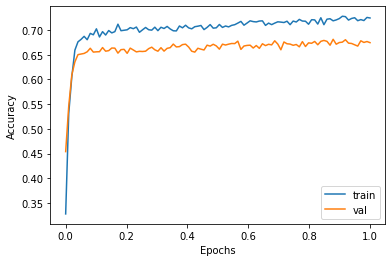

In [14]:
train_accs = results['train_accs']
val_accs = results['val_accs']
x = np.linspace(0, 1, len(train_accs))
plt.plot(x, train_accs, label = 'train')
plt.plot(x, val_accs, label = 'val')
plt.legend(loc='lower right')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
# plt.savefig('plots/cumulative_infection.png')
# plt.savefig('plots/cumulative_infection.eps', bbox_inches='tight')
plt.show()

In [15]:
train_data, train_labels, train_angles= get_mnist_data(mnist_trainset, digits = [5,6,7,8,9], n_samples = None, rotation_range=[-60, 61], rotate = False)
test_data, test_labels, test_angles = get_mnist_data(mnist_testset, digits = [5,6,7,8,9], n_samples = None, rotation_range=[-60, 61], rotate = False)
mnist_trainclassifier = [[train_data[i], train_labels[i]] for i in range(len(train_data))]
mnist_testclassifier = [[test_data[i], test_labels[i]] for i in range(len(test_data))]

In [16]:
import pickle
model = MLP()
model.to(device)
mlp_mnist_results = train_nn(model, rvae, mnist_trainclassifier, mnist_testclassifier, num_epochs = 100)
with open('saved_models/dict_rvae_rotated_mnist_other_half_classifier_z_100_test_plain.pkl', 'wb') as handle:
    pickle.dump(mlp_mnist_results, handle, protocol=pickle.HIGHEST_PROTOCOL)
torch.save(model.state_dict(), 'saved_models/rvae_rotated_mnist_other_half_classifier_z_100_test_plain.pkl')    
with open('saved_models/dict_rvae_rotated_mnist_other_half_classifier_z_100_test_plain.pkl', 'rb') as handle:
    results = pickle.load(handle)
model.load_state_dict(torch.load('saved_models/rvae_rotated_mnist_other_half_classifier_z_100_test_plain.pkl'))

100%|████████████████████████████████████████| 919/919 [00:05<00:00, 162.89it/s]


Epoch 0: Train Loss=1.936653296498661 Train Acc=59.23023861339966 Validation Acc=68.02971869328495%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 184.27it/s]


Epoch 1: Train Loss=1.793047284275715 Train Acc=68.28559769936267 Validation Acc=69.84318284936478%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 192.57it/s]


Epoch 2: Train Loss=1.7790830821544743 Train Acc=68.8607570340432 Validation Acc=69.72195440108892%


100%|████████████████████████████████████████| 919/919 [00:05<00:00, 165.90it/s]


Epoch 3: Train Loss=1.7706527808545334 Train Acc=69.4738069330017 Validation Acc=70.10832577132487%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 188.03it/s]


Epoch 4: Train Loss=1.7695755616106068 Train Acc=69.40968443960827 Validation Acc=69.30226293103449%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 191.66it/s]


Epoch 5: Train Loss=1.7686420475437798 Train Acc=69.45048966267682 Validation Acc=69.94385208711434%


100%|████████████████████████████████████████| 919/919 [00:05<00:00, 165.68it/s]


Epoch 6: Train Loss=1.7648693071485733 Train Acc=69.68852013057672 Validation Acc=71.01080421960073%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 190.82it/s]


Epoch 7: Train Loss=1.7634266398287701 Train Acc=69.89594668117519 Validation Acc=70.6449920598911%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 190.44it/s]


Epoch 8: Train Loss=1.7614528038037356 Train Acc=70.2447341831183 Validation Acc=70.33235027223232%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 191.82it/s]


Epoch 9: Train Loss=1.757304179266306 Train Acc=70.54591559148143 Validation Acc=71.33975158802178%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 189.21it/s]


Epoch 10: Train Loss=1.7547387784920527 Train Acc=70.63092647287425 Validation Acc=71.73463021778585%


100%|████████████████████████████████████████| 919/919 [00:05<00:00, 164.03it/s]


Epoch 11: Train Loss=1.753986649596263 Train Acc=70.74508394217317 Validation Acc=70.66767808529946%


100%|████████████████████████████████████████| 919/919 [00:05<00:00, 165.67it/s]


Epoch 12: Train Loss=1.7520446726754388 Train Acc=71.06861106793097 Validation Acc=71.73675703266788%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 186.13it/s]


Epoch 13: Train Loss=1.7471427593189692 Train Acc=71.52329783926628 Validation Acc=70.81159255898368%


100%|████████████████████████████████████████| 919/919 [00:05<00:00, 163.72it/s]


Epoch 14: Train Loss=1.7459416731916393 Train Acc=71.607822944194 Validation Acc=71.64601293103449%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 190.62it/s]


Epoch 15: Train Loss=1.7428342459380821 Train Acc=71.92114876418468 Validation Acc=71.1199807168784%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 186.65it/s]


Epoch 16: Train Loss=1.7414166959766724 Train Acc=72.05813772734338 Validation Acc=71.63821460980037%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 185.83it/s]


Epoch 17: Train Loss=1.740563225175403 Train Acc=72.13634773822477 Validation Acc=72.3698389292196%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 196.30it/s]


Epoch 18: Train Loss=1.740101415392364 Train Acc=72.25730607803513 Validation Acc=72.2528641107078%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 198.96it/s]


Epoch 19: Train Loss=1.739746536731201 Train Acc=72.12371755013214 Validation Acc=72.88169237749547%


100%|████████████████████████████████████████| 919/919 [00:05<00:00, 164.34it/s]


Epoch 20: Train Loss=1.737239303474717 Train Acc=72.4919361106793 Validation Acc=71.69776542649727%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 192.47it/s]


Epoch 21: Train Loss=1.737485011332183 Train Acc=72.37826441784549 Validation Acc=71.87854469147005%


100%|████████████████████████████████████████| 919/919 [00:05<00:00, 170.82it/s]


Epoch 22: Train Loss=1.7335233567718322 Train Acc=72.76299937820613 Validation Acc=72.7668443738657%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 186.94it/s]


Epoch 23: Train Loss=1.7369397458366005 Train Acc=72.39235193533344 Validation Acc=73.09791855716878%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 187.02it/s]


Epoch 24: Train Loss=1.7362746136492044 Train Acc=72.45744598165707 Validation Acc=72.70516674228675%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 191.52it/s]


Epoch 25: Train Loss=1.7318336032290453 Train Acc=72.93156381159646 Validation Acc=72.78314995462794%


100%|████████████████████████████████████████| 919/919 [00:05<00:00, 162.71it/s]


Epoch 26: Train Loss=1.7343277174967286 Train Acc=72.65952899113944 Validation Acc=72.45632940108892%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 195.03it/s]


Epoch 27: Train Loss=1.7341912117045903 Train Acc=72.70616353178922 Validation Acc=71.83955308529946%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 193.13it/s]


Epoch 28: Train Loss=1.7343996956506673 Train Acc=72.58714829783926 Validation Acc=72.78527676950999%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 207.49it/s]


Epoch 29: Train Loss=1.7307160418233363 Train Acc=73.05786569252292 Validation Acc=72.03876474591652%


100%|████████████████████████████████████████| 919/919 [00:05<00:00, 163.30it/s]


Epoch 30: Train Loss=1.7329169108377318 Train Acc=72.80040416601898 Validation Acc=73.42261229582577%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 212.14it/s]


Epoch 31: Train Loss=1.734243846302842 Train Acc=72.70810663764962 Validation Acc=72.62292990018149%


100%|████████████████████████████████████████| 919/919 [00:05<00:00, 181.56it/s]


Epoch 32: Train Loss=1.7323253916189383 Train Acc=72.7858308720659 Validation Acc=71.83742627041741%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 192.23it/s]


Epoch 33: Train Loss=1.7366176433739646 Train Acc=72.42101274677444 Validation Acc=72.6888611615245%


100%|████████████████████████████████████████| 919/919 [00:05<00:00, 165.04it/s]


Epoch 34: Train Loss=1.7315286004893538 Train Acc=72.90824654127157 Validation Acc=72.51375340290382%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 184.13it/s]


Epoch 35: Train Loss=1.7290923987171725 Train Acc=73.19825509093735 Validation Acc=72.45207577132487%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 188.50it/s]


Epoch 36: Train Loss=1.7336868805257488 Train Acc=72.65710010881394 Validation Acc=72.94975045372051%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 189.29it/s]


Epoch 37: Train Loss=1.7312037237839808 Train Acc=72.96508238768847 Validation Acc=72.47263498185119%


100%|████████████████████████████████████████| 919/919 [00:05<00:00, 160.37it/s]


Epoch 38: Train Loss=1.7318981630368901 Train Acc=72.87472796517955 Validation Acc=73.44955195099818%


100%|████████████████████████████████████████| 919/919 [00:05<00:00, 164.93it/s]


Epoch 39: Train Loss=1.7292455215578628 Train Acc=73.14239079745064 Validation Acc=72.75053879310344%


100%|████████████████████████████████████████| 919/919 [00:05<00:00, 169.98it/s]


Epoch 40: Train Loss=1.7271562856221745 Train Acc=73.2924957251671 Validation Acc=72.57755784936478%


100%|████████████████████████████████████████| 919/919 [00:05<00:00, 162.92it/s]


Epoch 41: Train Loss=1.7291189620232816 Train Acc=73.2133141613555 Validation Acc=73.02986048094373%


100%|████████████████████████████████████████| 919/919 [00:05<00:00, 182.31it/s]


Epoch 42: Train Loss=1.7287596228073419 Train Acc=73.22594434944816 Validation Acc=72.31028811252268%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 184.81it/s]


Epoch 43: Train Loss=1.72974263026224 Train Acc=73.0738963158713 Validation Acc=71.95652790381125%


100%|████████████████████████████████████████| 919/919 [00:05<00:00, 162.38it/s]


Epoch 44: Train Loss=1.7286351450898312 Train Acc=73.18805378517023 Validation Acc=73.34462908348458%


100%|████████████████████████████████████████| 919/919 [00:05<00:00, 159.67it/s]


Epoch 45: Train Loss=1.7294982791076676 Train Acc=73.08749805689413 Validation Acc=72.9618024047187%


100%|████████████████████████████████████████| 919/919 [00:05<00:00, 167.80it/s]


Epoch 46: Train Loss=1.7299936008401482 Train Acc=72.996172081455 Validation Acc=73.3013838475499%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 193.10it/s]


Epoch 47: Train Loss=1.7284056897780842 Train Acc=73.19096844396083 Validation Acc=73.03624092558984%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 187.49it/s]


Epoch 48: Train Loss=1.7285517320539538 Train Acc=73.13850458572982 Validation Acc=72.78527676950999%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 198.89it/s]


Epoch 49: Train Loss=1.730297617606162 Train Acc=72.98257034043215 Validation Acc=72.86964042649727%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 207.54it/s]


Epoch 50: Train Loss=1.7285353679522077 Train Acc=73.14287657391574 Validation Acc=72.04727200544464%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 207.27it/s]


Epoch 51: Train Loss=1.729356548083101 Train Acc=73.05349370433701 Validation Acc=73.23757940108892%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 190.13it/s]


Epoch 52: Train Loss=1.7290570571191681 Train Acc=73.1069291154982 Validation Acc=73.1184777676951%


100%|████████████████████████████████████████| 919/919 [00:05<00:00, 163.13it/s]


Epoch 53: Train Loss=1.7296075447339876 Train Acc=73.03066221047723 Validation Acc=72.39890539927404%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 194.32it/s]


Epoch 54: Train Loss=1.7299058330980037 Train Acc=73.06418078656925 Validation Acc=72.86325998185119%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 188.36it/s]


Epoch 55: Train Loss=1.7289346696502885 Train Acc=73.0481501632209 Validation Acc=72.80370916515426%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 192.07it/s]


Epoch 56: Train Loss=1.724432021022751 Train Acc=73.68063112078346 Validation Acc=73.60126474591652%


100%|████████████████████████████████████████| 919/919 [00:05<00:00, 161.44it/s]


Epoch 57: Train Loss=1.7242398745865766 Train Acc=73.71074926161977 Validation Acc=72.97030966424683%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 190.64it/s]


Epoch 58: Train Loss=1.7288493933693239 Train Acc=73.14870589149697 Validation Acc=73.33824863883848%


100%|████████████████████████████████████████| 919/919 [00:05<00:00, 165.90it/s]


Epoch 59: Train Loss=1.7272966058521457 Train Acc=73.2356598787502 Validation Acc=73.82954287658802%


100%|████████████████████████████████████████| 919/919 [00:05<00:00, 163.03it/s]


Epoch 60: Train Loss=1.730291360480482 Train Acc=73.01851779884969 Validation Acc=73.21276656079854%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 192.76it/s]


Epoch 61: Train Loss=1.727015478956038 Train Acc=73.26529224312141 Validation Acc=73.09153811252268%


100%|████████████████████████████████████████| 919/919 [00:05<00:00, 170.95it/s]


Epoch 62: Train Loss=1.7269059553239758 Train Acc=73.29638193688793 Validation Acc=73.58921279491832%


100%|████████████████████████████████████████| 919/919 [00:05<00:00, 176.32it/s]


Epoch 63: Train Loss=1.7292560362322935 Train Acc=73.07049588061557 Validation Acc=73.3134357985481%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 191.21it/s]


Epoch 64: Train Loss=1.727031762503955 Train Acc=73.30901212498057 Validation Acc=73.76786524500908%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 215.30it/s]


Epoch 65: Train Loss=1.7265695159660979 Train Acc=73.29395305456241 Validation Acc=72.91501247731397%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 184.70it/s]


Epoch 66: Train Loss=1.7309236875426133 Train Acc=72.82177833048344 Validation Acc=72.80158235027223%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 198.70it/s]


Epoch 67: Train Loss=1.7277041700900704 Train Acc=73.35030312451421 Validation Acc=73.00717445553539%


100%|████████████████████████████████████████| 919/919 [00:05<00:00, 160.32it/s]


Epoch 68: Train Loss=1.7274686048806558 Train Acc=73.28229441939996 Validation Acc=72.06145077132487%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 187.88it/s]


Epoch 69: Train Loss=1.7290775525556945 Train Acc=73.07875408052232 Validation Acc=73.21914700544464%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 187.03it/s]


Epoch 70: Train Loss=1.7293674071543366 Train Acc=72.98985698740866 Validation Acc=73.31768942831216%


100%|████████████████████████████████████████| 919/919 [00:05<00:00, 173.85it/s]


Epoch 71: Train Loss=1.7263733427464898 Train Acc=73.37944971242034 Validation Acc=73.0731057168784%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 193.38it/s]


Epoch 72: Train Loss=1.726985743307834 Train Acc=73.31192678377117 Validation Acc=73.36306147912886%


100%|████████████████████████████████████████| 919/919 [00:05<00:00, 165.44it/s]


Epoch 73: Train Loss=1.7310604041237567 Train Acc=72.9174762941085 Validation Acc=73.08941129764065%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 187.91it/s]


Epoch 74: Train Loss=1.7272102690106248 Train Acc=73.35953287735116 Validation Acc=72.84695440108892%


100%|████████████████████████████████████████| 919/919 [00:05<00:00, 163.41it/s]


Epoch 75: Train Loss=1.7271955263627625 Train Acc=73.37021995958341 Validation Acc=72.98661524500908%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 185.53it/s]


Epoch 76: Train Loss=1.7264269943206172 Train Acc=73.38527903000156 Validation Acc=72.86751361161524%


100%|████████████████████████████████████████| 919/919 [00:05<00:00, 163.73it/s]


Epoch 77: Train Loss=1.7253797927281542 Train Acc=73.31678454842219 Validation Acc=72.83277563520872%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 187.37it/s]


Epoch 78: Train Loss=1.7238930830888053 Train Acc=73.5344124047878 Validation Acc=72.08839042649727%


100%|████████████████████████████████████████| 919/919 [00:05<00:00, 164.47it/s]


Epoch 79: Train Loss=1.727808756978779 Train Acc=73.18853956163531 Validation Acc=73.28295145190563%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 186.49it/s]


Epoch 80: Train Loss=1.7222420642632785 Train Acc=73.8011036841287 Validation Acc=73.73525408348458%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 197.73it/s]


Epoch 81: Train Loss=1.723724221638419 Train Acc=73.59853489818124 Validation Acc=73.34250226860254%


100%|████████████████████████████████████████| 919/919 [00:05<00:00, 179.00it/s]


Epoch 82: Train Loss=1.7258608671993634 Train Acc=73.46931835846416 Validation Acc=72.70303992740472%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 195.47it/s]


Epoch 83: Train Loss=1.7280467967862534 Train Acc=73.1788240323333 Validation Acc=73.83166969147005%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 199.74it/s]


Epoch 84: Train Loss=1.7259296619853206 Train Acc=73.40471008860561 Validation Acc=73.81323729582577%


100%|████████████████████████████████████████| 919/919 [00:05<00:00, 165.43it/s]


Epoch 85: Train Loss=1.7226039325581282 Train Acc=73.8268498367791 Validation Acc=72.78527676950999%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 191.32it/s]


Epoch 86: Train Loss=1.723301698774975 Train Acc=73.73163764961916 Validation Acc=72.80158235027223%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 186.97it/s]


Epoch 87: Train Loss=1.7256257527541283 Train Acc=73.41442561790767 Validation Acc=73.66294237749547%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 186.26it/s]


Epoch 88: Train Loss=1.7264392626298524 Train Acc=73.40713897093113 Validation Acc=73.07097890199637%


100%|████████████████████████████████████████| 919/919 [00:05<00:00, 165.21it/s]


Epoch 89: Train Loss=1.724847063535705 Train Acc=73.57473185139126 Validation Acc=72.80370916515426%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 194.00it/s]


Epoch 90: Train Loss=1.7259796668448049 Train Acc=73.41102518265195 Validation Acc=72.98661524500908%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 184.93it/s]


Epoch 91: Train Loss=1.7259202885549916 Train Acc=73.38187859474584 Validation Acc=72.51588021778585%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 195.64it/s]


Epoch 92: Train Loss=1.7270851872042552 Train Acc=73.24003186693612 Validation Acc=72.70091311252268%


100%|████████████████████████████████████████| 919/919 [00:05<00:00, 171.59it/s]


Epoch 93: Train Loss=1.7263608498983207 Train Acc=73.33232939530545 Validation Acc=72.48114224137932%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 193.68it/s]


Epoch 94: Train Loss=1.7222348123432114 Train Acc=73.75544069640914 Validation Acc=72.6371086660617%


100%|████████████████████████████████████████| 919/919 [00:05<00:00, 174.56it/s]


Epoch 95: Train Loss=1.7240853605384536 Train Acc=73.56550209855433 Validation Acc=72.56125226860254%


100%|████████████████████████████████████████| 919/919 [00:05<00:00, 183.58it/s]


Epoch 96: Train Loss=1.7242181216801342 Train Acc=73.60339266283226 Validation Acc=72.60024387477314%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 190.42it/s]


Epoch 97: Train Loss=1.7248383032743768 Train Acc=73.43871444116274 Validation Acc=73.62607758620689%


100%|████████████████████████████████████████| 919/919 [00:05<00:00, 162.07it/s]


Epoch 98: Train Loss=1.7260334124632577 Train Acc=73.35467511270014 Validation Acc=73.09579174228675%


100%|████████████████████████████████████████| 919/919 [00:05<00:00, 173.49it/s]


Epoch 99: Train Loss=1.7232708822007536 Train Acc=73.70200528524794 Validation Acc=72.55061819419237%


<All keys matched successfully>

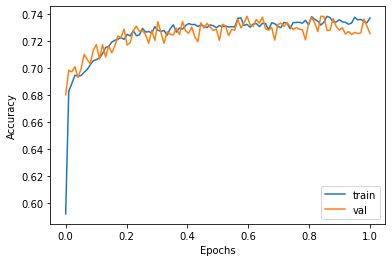

In [18]:
train_accs = results['train_accs']
val_accs = results['val_accs']
x = np.linspace(0, 1, len(train_accs))
plt.plot(x, train_accs, label = 'train')
plt.plot(x, val_accs, label = 'val')
plt.legend(loc='lower right')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
# plt.savefig('plots/cumulative_infection.png')
# plt.savefig('plots/cumulative_infection.eps', bbox_inches='tight')
plt.show()

In [19]:
train_data, train_labels, train_angles= get_mnist_data(mnist_trainset, digits = [5,6,7,8,9], n_samples = None, rotation_range=[-60, 61], rotate = False)
test_data, test_labels, test_angles = get_mnist_data(mnist_testset, digits = [5,6,7,8,9], n_samples = None, rotation_range=[-60, 61], rotate = True)
mnist_trainclassifier = [[train_data[i], train_labels[i]] for i in range(len(train_data))]
mnist_testclassifier = [[test_data[i], test_labels[i]] for i in range(len(test_data))]

In [20]:
import pickle
model = MLP()
model.to(device)
mlp_mnist_results = train_nn(model, rvae, mnist_trainclassifier, mnist_testclassifier, num_epochs = 100)
with open('saved_models/dict_rvae_rotated_mnist_other_half_classifier_z_100_test_rotate.pkl', 'wb') as handle:
    pickle.dump(mlp_mnist_results, handle, protocol=pickle.HIGHEST_PROTOCOL)
torch.save(model.state_dict(), 'saved_models/rvae_rotated_mnist_other_half_classifier_z_100_test_rotate.pkl')    
with open('saved_models/dict_rvae_rotated_mnist_other_half_classifier_z_100_test_rotate.pkl', 'rb') as handle:
    results = pickle.load(handle)
model.load_state_dict(torch.load('saved_models/rvae_rotated_mnist_other_half_classifier_z_100_test_rotate.pkl'))

100%|████████████████████████████████████████| 919/919 [00:05<00:00, 161.55it/s]


Epoch 0: Train Loss=1.9408094744168636 Train Acc=58.443280739934714 Validation Acc=64.88415948275863%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 192.79it/s]


Epoch 1: Train Loss=1.7922232745132198 Train Acc=68.26568086429349 Validation Acc=65.9964836660617%


100%|████████████████████████████████████████| 919/919 [00:05<00:00, 167.30it/s]


Epoch 2: Train Loss=1.775958711356411 Train Acc=69.2838683351469 Validation Acc=65.55835980036298%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 188.39it/s]


Epoch 3: Train Loss=1.7721361713129236 Train Acc=69.3902533810042 Validation Acc=65.35914813974591%


100%|████████████████████████████████████████| 919/919 [00:05<00:00, 167.65it/s]


Epoch 4: Train Loss=1.7672863948332214 Train Acc=69.53112855588373 Validation Acc=65.73134074410163%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 194.03it/s]


Epoch 5: Train Loss=1.7677611416130772 Train Acc=69.53550054406963 Validation Acc=66.35804219600726%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 188.23it/s]


Epoch 6: Train Loss=1.7637221736669282 Train Acc=69.88914581066376 Validation Acc=66.31905058983666%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 198.55it/s]


Epoch 7: Train Loss=1.7646760151876588 Train Acc=69.65403000155447 Validation Acc=65.5009357985481%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 195.01it/s]


Epoch 8: Train Loss=1.758011213454121 Train Acc=70.34820457018498 Validation Acc=66.06028811252268%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 191.75it/s]


Epoch 9: Train Loss=1.757813826349277 Train Acc=70.42495725167107 Validation Acc=66.862097323049%


100%|████████████████████████████████████████| 919/919 [00:05<00:00, 163.87it/s]


Epoch 10: Train Loss=1.7543287447150047 Train Acc=70.76208611845173 Validation Acc=66.6153867967332%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 190.70it/s]


Epoch 11: Train Loss=1.7503825341786083 Train Acc=71.09047100886056 Validation Acc=67.1293670598911%


100%|████████████████████████████████████████| 919/919 [00:05<00:00, 178.35it/s]


Epoch 12: Train Loss=1.7514395626896224 Train Acc=71.09241411472097 Validation Acc=66.5884471415608%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 195.65it/s]


Epoch 13: Train Loss=1.7447136724864307 Train Acc=71.71906575470233 Validation Acc=66.42397345735027%


100%|████████████████████████████████████████| 919/919 [00:05<00:00, 168.65it/s]


Epoch 14: Train Loss=1.7454485401624693 Train Acc=71.74626923674803 Validation Acc=66.63169237749547%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 192.86it/s]


Epoch 15: Train Loss=1.7396245345197643 Train Acc=72.37000621793875 Validation Acc=68.0729639292196%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 192.12it/s]


Epoch 16: Train Loss=1.742778040898378 Train Acc=71.96826908129955 Validation Acc=66.52464269509983%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 192.56it/s]


Epoch 17: Train Loss=1.7376466732678917 Train Acc=72.5171964868646 Validation Acc=68.09777676950999%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 192.43it/s]


Epoch 18: Train Loss=1.7371655725939879 Train Acc=72.5696603450956 Validation Acc=66.55158235027223%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 188.66it/s]


Epoch 19: Train Loss=1.7371420104044435 Train Acc=72.50262319291154 Validation Acc=67.54055127041741%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 193.05it/s]


Epoch 20: Train Loss=1.737304505897165 Train Acc=72.53128400435256 Validation Acc=67.80994782214155%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 206.10it/s]


Epoch 21: Train Loss=1.7362821255207581 Train Acc=72.6235815327219 Validation Acc=68.07721755898368%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 214.22it/s]


Epoch 22: Train Loss=1.7370771145016377 Train Acc=72.51379605160888 Validation Acc=67.47249319419237%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 211.63it/s]


Epoch 23: Train Loss=1.7351472408909014 Train Acc=72.57500388621172 Validation Acc=67.80144056261342%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 215.96it/s]


Epoch 24: Train Loss=1.7318133821425163 Train Acc=73.00783071661745 Validation Acc=68.29698843012704%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 191.68it/s]


Epoch 25: Train Loss=1.7330096495683356 Train Acc=72.79506062490285 Validation Acc=67.88793103448276%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 191.60it/s]


Epoch 26: Train Loss=1.733043452341746 Train Acc=72.85821156536608 Validation Acc=68.38347890199637%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 195.28it/s]


Epoch 27: Train Loss=1.7316012267059808 Train Acc=72.94662288201462 Validation Acc=68.71667990018149%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 193.38it/s]


Epoch 28: Train Loss=1.7338026780168951 Train Acc=72.76542826053162 Validation Acc=68.48627495462794%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 208.02it/s]


Epoch 29: Train Loss=1.733717968466492 Train Acc=72.53128400435256 Validation Acc=67.47887363883848%


100%|████████████████████████████████████████| 919/919 [00:05<00:00, 173.15it/s]


Epoch 30: Train Loss=1.7341162922333062 Train Acc=72.5133102751438 Validation Acc=68.05453153357531%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 190.83it/s]


Epoch 31: Train Loss=1.7346660466915376 Train Acc=72.55508705114254 Validation Acc=67.76882940108892%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 192.15it/s]


Epoch 32: Train Loss=1.7346211701663976 Train Acc=72.74405409606715 Validation Acc=68.29486161524501%


100%|████████████████████████████████████████| 919/919 [00:05<00:00, 164.67it/s]


Epoch 33: Train Loss=1.7333544129515888 Train Acc=72.79603217783304 Validation Acc=67.30801950998185%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 193.33it/s]


Epoch 34: Train Loss=1.7309642971794286 Train Acc=72.95002331727034 Validation Acc=68.36079287658802%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 192.51it/s]


Epoch 35: Train Loss=1.7326395176959115 Train Acc=72.79360329550755 Validation Acc=67.75819532667877%


100%|████████████████████████████████████████| 919/919 [00:05<00:00, 164.02it/s]


Epoch 36: Train Loss=1.7317884496298657 Train Acc=72.85141069485465 Validation Acc=68.42247050816697%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 184.31it/s]


Epoch 37: Train Loss=1.7305584261285079 Train Acc=72.99665785792008 Validation Acc=68.21475158802178%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 189.87it/s]


Epoch 38: Train Loss=1.7297422539552225 Train Acc=73.0758394217317 Validation Acc=68.01553992740472%


100%|████████████████████████████████████████| 919/919 [00:05<00:00, 176.26it/s]


Epoch 39: Train Loss=1.7274607601570486 Train Acc=73.32261386600342 Validation Acc=68.13889519056261%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 190.78it/s]


Epoch 40: Train Loss=1.7310547804028218 Train Acc=72.90824654127157 Validation Acc=68.18781193284936%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 189.29it/s]


Epoch 41: Train Loss=1.7284535371958885 Train Acc=73.27889398414426 Validation Acc=67.64122050816697%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 189.16it/s]


Epoch 42: Train Loss=1.7294401553042955 Train Acc=73.05495103373232 Validation Acc=68.69753856624318%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 193.25it/s]


Epoch 43: Train Loss=1.7285013114536938 Train Acc=73.10595756256801 Validation Acc=68.4699693738657%


100%|████████████████████████████████████████| 919/919 [00:05<00:00, 163.22it/s]


Epoch 44: Train Loss=1.7300197768133534 Train Acc=73.10207135084718 Validation Acc=68.00703266787659%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 192.20it/s]


Epoch 45: Train Loss=1.730129281895983 Train Acc=73.06903855122027 Validation Acc=68.27855603448276%


100%|████████████████████████████████████████| 919/919 [00:05<00:00, 167.21it/s]


Epoch 46: Train Loss=1.7310724887546958 Train Acc=72.91407585885278 Validation Acc=67.8836774047187%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 187.55it/s]


Epoch 47: Train Loss=1.7284638277205342 Train Acc=73.19922664386756 Validation Acc=69.57378629764065%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 193.03it/s]


Epoch 48: Train Loss=1.7285829059966111 Train Acc=73.20165552619308 Validation Acc=67.1683586660617%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 194.74it/s]


Epoch 49: Train Loss=1.7263605450649906 Train Acc=73.41151095911704 Validation Acc=69.16260208711434%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 193.67it/s]


Epoch 50: Train Loss=1.7294277175855586 Train Acc=73.1579356443339 Validation Acc=67.52424568965517%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 193.36it/s]


Epoch 51: Train Loss=1.730822154954157 Train Acc=72.8873581532722 Validation Acc=67.17048548094373%


100%|████████████████████████████████████████| 919/919 [00:05<00:00, 169.66it/s]


Epoch 52: Train Loss=1.7276820862773195 Train Acc=73.1861106793098 Validation Acc=67.3966367967332%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 189.44it/s]


Epoch 53: Train Loss=1.7278822817402903 Train Acc=73.21865770247163 Validation Acc=67.643347323049%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 194.38it/s]


Epoch 54: Train Loss=1.7298301267675789 Train Acc=73.00005829317581 Validation Acc=68.58269056261342%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 192.70it/s]


Epoch 55: Train Loss=1.7294570838017096 Train Acc=73.04523550443028 Validation Acc=68.44302971869328%


100%|████████████████████████████████████████| 919/919 [00:05<00:00, 173.80it/s]


Epoch 56: Train Loss=1.7250784754882829 Train Acc=73.48583475827763 Validation Acc=68.06871029945553%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 193.55it/s]


Epoch 57: Train Loss=1.726330968708416 Train Acc=73.38867946525727 Validation Acc=67.47674682395645%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 184.29it/s]


Epoch 58: Train Loss=1.7288117464530455 Train Acc=73.11567309187004 Validation Acc=67.13149387477314%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 190.97it/s]


Epoch 59: Train Loss=1.7289123035748453 Train Acc=73.11227265661432 Validation Acc=68.23956442831216%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 189.33it/s]


Epoch 60: Train Loss=1.7292945230616839 Train Acc=73.03600575159335 Validation Acc=67.94535503629764%


100%|████████████████████████████████████████| 919/919 [00:05<00:00, 179.42it/s]


Epoch 61: Train Loss=1.7278880411444861 Train Acc=73.23906031400591 Validation Acc=68.95488316696915%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 191.43it/s]


Epoch 62: Train Loss=1.7283546666455607 Train Acc=73.1564783149386 Validation Acc=68.21900521778585%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 192.05it/s]


Epoch 63: Train Loss=1.727129304240396 Train Acc=73.36099020674646 Validation Acc=68.21475158802178%


100%|████████████████████████████████████████| 919/919 [00:05<00:00, 166.51it/s]


Epoch 64: Train Loss=1.7286875302436173 Train Acc=73.18173869112388 Validation Acc=69.10092445553539%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 191.95it/s]


Epoch 65: Train Loss=1.7261794847035954 Train Acc=73.35661821856056 Validation Acc=67.57528924682396%


100%|████████████████████████████████████████| 919/919 [00:05<00:00, 168.13it/s]


Epoch 66: Train Loss=1.7261381992448013 Train Acc=73.38139281828074 Validation Acc=68.46784255898368%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 192.12it/s]


Epoch 67: Train Loss=1.7289942566536456 Train Acc=73.14822011503188 Validation Acc=67.6823389292196%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 193.36it/s]


Epoch 68: Train Loss=1.7289423952943224 Train Acc=73.09381315094046 Validation Acc=68.85846755898368%


100%|████████████████████████████████████████| 919/919 [00:05<00:00, 177.93it/s]


Epoch 69: Train Loss=1.7300011217918438 Train Acc=72.92233405875952 Validation Acc=68.51250567150635%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 191.13it/s]


Epoch 70: Train Loss=1.7274561397917771 Train Acc=73.26189180786568 Validation Acc=69.10305127041741%


100%|████████████████████████████████████████| 919/919 [00:05<00:00, 174.86it/s]


Epoch 71: Train Loss=1.7272094613968743 Train Acc=73.2905526193067 Validation Acc=67.79151542649727%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 192.29it/s]


Epoch 72: Train Loss=1.7273710923303847 Train Acc=73.24197497279653 Validation Acc=68.23743761343013%


100%|████████████████████████████████████████| 919/919 [00:05<00:00, 166.39it/s]


Epoch 73: Train Loss=1.7274905043665292 Train Acc=73.16570806777553 Validation Acc=68.03184550816697%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 190.46it/s]


Epoch 74: Train Loss=1.7254976311757333 Train Acc=73.47369034665009 Validation Acc=68.03609913793103%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 191.52it/s]


Epoch 75: Train Loss=1.7255226583812908 Train Acc=73.46980413492928 Validation Acc=67.50155966424683%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 192.87it/s]


Epoch 76: Train Loss=1.7271600542701497 Train Acc=73.26334913726099 Validation Acc=68.5089609800363%


100%|████████████████████████████████████████| 919/919 [00:05<00:00, 164.49it/s]


Epoch 77: Train Loss=1.72309276224869 Train Acc=73.65197030934245 Validation Acc=68.22113203266788%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 190.64it/s]


Epoch 78: Train Loss=1.7271456138612915 Train Acc=73.28083709000467 Validation Acc=68.77197708711434%


100%|████████████████████████████████████████| 919/919 [00:05<00:00, 166.02it/s]


Epoch 79: Train Loss=1.7275310285202956 Train Acc=73.26917845484222 Validation Acc=67.6043557168784%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 195.34it/s]


Epoch 80: Train Loss=1.7296812263225185 Train Acc=73.08118296284782 Validation Acc=68.21475158802178%


100%|████████████████████████████████████████| 919/919 [00:05<00:00, 178.01it/s]


Epoch 81: Train Loss=1.7268144756198838 Train Acc=73.28569485465567 Validation Acc=68.64862182395645%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 190.15it/s]


Epoch 82: Train Loss=1.7255718244951102 Train Acc=73.46640369967355 Validation Acc=68.64649500907441%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 189.38it/s]


Epoch 83: Train Loss=1.728124752786655 Train Acc=73.182224467589 Validation Acc=68.21900521778585%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 193.38it/s]


Epoch 84: Train Loss=1.7237813749043545 Train Acc=73.60144955697187 Validation Acc=67.78513498185119%


100%|████████████████████████████████████████| 919/919 [00:05<00:00, 160.84it/s]


Epoch 85: Train Loss=1.7315868463557744 Train Acc=72.74453987253226 Validation Acc=69.5184891107078%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 191.05it/s]


Epoch 86: Train Loss=1.7275436006251306 Train Acc=73.19825509093735 Validation Acc=68.31967445553539%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 191.05it/s]


Epoch 87: Train Loss=1.7283043234859379 Train Acc=73.01463158712887 Validation Acc=67.55473003629764%


100%|████████████████████████████████████████| 919/919 [00:05<00:00, 173.42it/s]


Epoch 88: Train Loss=1.7259969131471802 Train Acc=73.39159412404787 Validation Acc=67.76882940108892%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 191.10it/s]


Epoch 89: Train Loss=1.722950678784907 Train Acc=73.66945826208612 Validation Acc=67.08824863883848%


100%|████████████████████████████████████████| 919/919 [00:05<00:00, 173.02it/s]


Epoch 90: Train Loss=1.7223364979969145 Train Acc=73.7704997668273 Validation Acc=68.72873185117967%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 194.46it/s]


Epoch 91: Train Loss=1.7243622112066623 Train Acc=73.6364254624592 Validation Acc=68.424597323049%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 190.87it/s]


Epoch 92: Train Loss=1.7244548155511683 Train Acc=73.58881936887923 Validation Acc=67.70077132486388%


100%|████████████████████████████████████████| 919/919 [00:05<00:00, 171.53it/s]


Epoch 93: Train Loss=1.7279201085730918 Train Acc=73.20554173791388 Validation Acc=68.87477313974591%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 186.41it/s]


Epoch 94: Train Loss=1.7250565614741826 Train Acc=73.54849992227577 Validation Acc=67.80782100725953%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 187.59it/s]


Epoch 95: Train Loss=1.7258325419566058 Train Acc=73.38479325353646 Validation Acc=68.46146211433756%


100%|████████████████████████████████████████| 919/919 [00:05<00:00, 179.84it/s]


Epoch 96: Train Loss=1.7244402475014604 Train Acc=73.62913881548266 Validation Acc=68.67130784936478%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 190.48it/s]


Epoch 97: Train Loss=1.725173793887158 Train Acc=73.4523161821856 Validation Acc=68.44515653357531%


100%|████████████████████████████████████████| 919/919 [00:05<00:00, 167.01it/s]


Epoch 98: Train Loss=1.726632730356368 Train Acc=73.28035131353955 Validation Acc=68.033972323049%


100%|████████████████████████████████████████| 919/919 [00:04<00:00, 187.92it/s]


Epoch 99: Train Loss=1.7270114328448738 Train Acc=73.2084563967045 Validation Acc=68.01341311252268%


<All keys matched successfully>

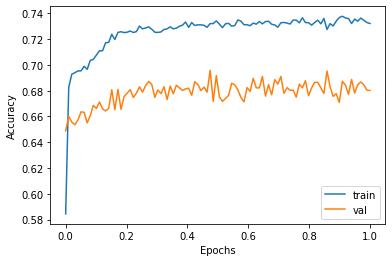

In [21]:
train_accs = results['train_accs']
val_accs = results['val_accs']
x = np.linspace(0, 1, len(train_accs))
plt.plot(x, train_accs, label = 'train')
plt.plot(x, val_accs, label = 'val')
plt.legend(loc='lower right')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
# plt.savefig('plots/cumulative_infection.png')
# plt.savefig('plots/cumulative_infection.eps', bbox_inches='tight')
plt.show()

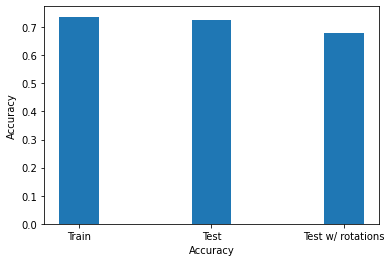

In [21]:
import pickle
with open('saved_models/dict_rvae_rotated_mnist_other_half_classifier_z_100_test_plain.pkl', 'rb') as handle:
    results1 = pickle.load(handle)
with open('saved_models/dict_rvae_rotated_mnist_other_half_classifier_z_100_test_rotate.pkl', 'rb') as handle:
    results2 = pickle.load(handle)
x = ['Train', 'Test', 'Test w/ rotations']
y = [results1['train_accs'][-1], results1['val_accs'][-1], results2['val_accs'][-1]]

# fig = plt.figure(figsize = (10, 5))
# plt.bar(x, y, color ='maroon',width = 0.4)
plt.bar(x, y,width = 0.3)
plt.xlabel("Accuracy")
plt.ylabel("Accuracy")
plt.savefig('acc_half_labels.svg', bbox_inches='tight')

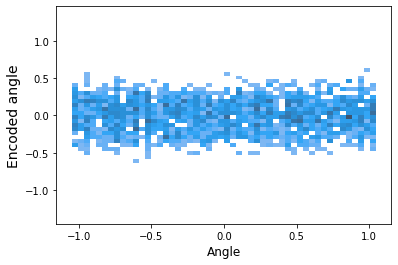

In [13]:
test_data, test_labels, test_angles = get_mnist_data(mnist_testset, digits = [0,1,2,3,4], n_samples = None, rotation_range=[-60, 61], rotate = False)
z = rvae.encode(test_data)
z_mu, z_sigma = z[0], z[1]
z_sample = z_mu + torch.randn_like(z_mu)*z_sigma
plt.xlabel("Angle", fontsize=12)
plt.ylabel("Encoded angle", fontsize=14)
ax = sns.histplot(x=test_angles, y=z_mu[:, 0], bins=50, pthresh=.1);

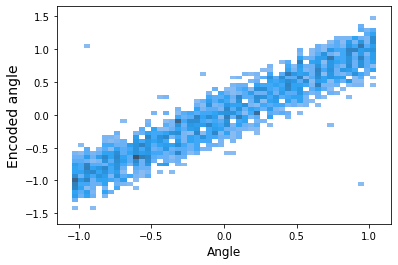

In [14]:
test_data, test_labels, test_angles = get_mnist_data(mnist_testset, digits = [0,1,2,3,4], n_samples = None, rotation_range=[-60, 61], rotate = True)
z = rvae.encode(test_data)
z_mu, z_sigma = z[0], z[1]
z_sample = z_mu + torch.randn_like(z_mu)*z_sigma
plt.xlabel("Angle", fontsize=12)
plt.ylabel("Encoded angle", fontsize=14)
ax = sns.histplot(x=test_angles, y=z_mu[:, 0], bins=50, pthresh=.1);

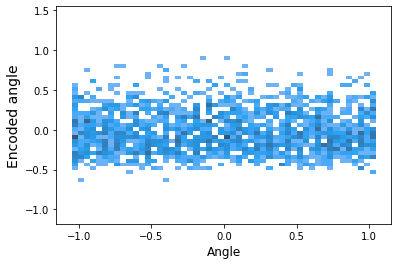

In [15]:
test_data, test_labels, test_angles = get_mnist_data(mnist_testset, digits = [5,6,7,8,9], n_samples = None, rotation_range=[-60, 61], rotate = False)
z = rvae.encode(test_data)
z_mu, z_sigma = z[0], z[1]
z_sample = z_mu + torch.randn_like(z_mu)*z_sigma
plt.xlabel("Angle", fontsize=12)
plt.ylabel("Encoded angle", fontsize=14)
ax = sns.histplot(x=test_angles, y=z_mu[:, 0], bins=50, pthresh=.1);

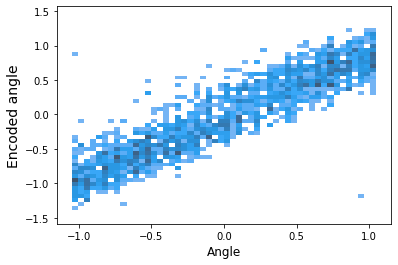

In [9]:
test_data, test_labels, test_angles = get_mnist_data(mnist_testset, digits = [5,6,7,8,9], n_samples = None, rotation_range=[-60, 61], rotate = True)
z = rvae.encode(test_data)
z_mu, z_sigma = z[0], z[1]
z_sample = z_mu + torch.randn_like(z_mu)*z_sigma
plt.xlabel("Angle", fontsize=12)
plt.ylabel("Encoded angle", fontsize=14)
ax = sns.histplot(x=test_angles, y=z_mu[:, 0], bins=50, pthresh=.1)
plt.savefig('predicted_angles_half_labels.svg', bbox_inches='tight')

# Similarity

In [13]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_curve, roc_auc_score
from scikitplot.metrics import plot_roc_curve
import matplotlib.pyplot as plt

In [8]:
def pair_matching(test_labels, model, plot = False, plot_label = None):
    #pair of corresponding rotated image
    test_data1, test_labels1, test_angles1 = get_mnist_data(mnist_testset, digits = test_labels, n_samples = None, rotation_range=[-60, 61], rotate = False)
    test_data2, test_labels2, test_angles2 = get_mnist_data(mnist_testset, digits = test_labels, n_samples = None, rotation_range=[-60, 61], rotate = True)
    idx = torch.arange(test_labels2.size()[0])
    same_label = torch.ones((test_labels1.size()[0]))

    #shuffled pairs
    indices = torch.randperm(test_labels2.size()[0])
    test_data2_shuffled = test_data2[indices]
    test_labels2_shuffled = test_labels2[indices]
    same_label_shuffled = (indices==idx).long()

    # we are only interested in checking if a pair of two images(rotated and non-rotated) are same or not (irrespective of label)
    point1 = torch.cat([test_data1, test_data1])
    point2 = torch.cat([test_data2, test_data2_shuffled])
    label = torch.cat([same_label, same_label_shuffled])

    z1 = model.encode(point1)
    z_mu1, z_sigma1 = z1[0], z1[1]
    z_sample1 = z_mu1 + torch.randn_like(z_mu1)*z_sigma1

    z2 = model.encode(point2)
    z_mu2, z_sigma2 = z2[0], z2[1]
    z_sample2 = z_mu2 + torch.randn_like(z_mu2)*z_sigma2

    point1 = z_mu1[:, 1:]
    point2 = z_mu2[:, 1:]
    
    cos = torch.nn.CosineSimilarity(dim=1)
    scores = cos(point1, point2)
    fpr, tpr, thresholds = roc_curve(label, scores, pos_label=1)
    # plot_roc_curve(label, scores)
    auc = roc_auc_score(label, scores)
    
    if plot==True:
    plt.plot(fpr,tpr,label=plot_label+ ", auc="+str(auc))
    plt.legend(loc=4)
    plt.show()
    return auc

In [9]:
import matplotlib.pyplot as plt
def class_matching(test_labels, model, plot = False, plot_label = None):
    #pair of corresponding rotated image
    test_data1, test_labels1, test_angles1 = get_mnist_data(mnist_testset, digits = test_labels, n_samples = None, rotation_range=[-60, 61], rotate = False)
    test_data2, test_labels2, test_angles2 = get_mnist_data(mnist_testset, digits = test_labels, n_samples = None, rotation_range=[-60, 61], rotate = True)
    idx = torch.arange(test_labels2.size()[0])
    same_label = torch.ones((test_labels1.size()[0]))

    #shuffled pairs
    indices = torch.randperm(test_labels2.size()[0])
    test_data2_shuffled = test_data2[indices]
    test_labels2_shuffled = test_labels2[indices]
    same_label_shuffled = (test_labels2_shuffled==test_labels1).long()

    # we are only interested in checking if a pair of two images(rotated and non-rotated) are same or not (for same class label-> should be same)
    point1 = torch.cat([test_data1, test_data1])
    point2 = torch.cat([test_data2, test_data2_shuffled])
    label = torch.cat([same_label, same_label_shuffled])

    z1 = model.encode(point1)
    z_mu1, z_sigma1 = z1[0], z1[1]
    z_sample1 = z_mu1 + torch.randn_like(z_mu1)*z_sigma1

    z2 = model.encode(point2)
    z_mu2, z_sigma2 = z2[0], z2[1]
    z_sample2 = z_mu2 + torch.randn_like(z_mu2)*z_sigma2

    point1 = z_mu1[:, 1:]
    point2 = z_mu2[:, 1:]
    
    cos = torch.nn.CosineSimilarity(dim=1)
    scores = cos(point1, point2)
    fpr, tpr, thresholds = roc_curve(label, scores, pos_label=1)
    # plot_roc_curve(label, scores)
    auc = roc_auc_score(label, scores)
    if plot==True:
        plt.plot(fpr,tpr,label=plot_label+ ", auc="+str(auc))
        plt.legend(loc=4)
        plt.show()
    return auc

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sn
def plot_sample_heatmap(model, test_labels)
    test_data1, test_labels1, test_angles1 = get_mnist_data(mnist_testset, digits = test_labels, n_samples = None, rotation_range=[-60, 61], rotate = False)
    test_data2, test_labels2, test_angles2 = get_mnist_data(mnist_testset, digits = test_labels, n_samples = None, rotation_range=[-60, 61], rotate = True)
    
    z1 = model.encode(test_data1[:10])
    z_mu1, z_sigma1 = z1[0], z1[1]
    z_sample1 = z_mu1 + torch.randn_like(z_mu1)*z_sigma1

    z2 = model.encode(test_data2[:10])
    z_mu2, z_sigma2 = z2[0], z2[1]
    z_sample2 = z_mu2 + torch.randn_like(z_mu2)*z_sigma2

    point1 = z_mu1[:, 1:]
    point2 = z_mu2[:, 1:]
    
    scores = cosine_similarity(point1, point2)
    heatmap = sn.heatmap(scores, annot=True)
    fig = heatmap.get_figure()
    # fig.savefig("heatmap.svg") 

In [14]:
rvae = rVAE((28, 28), latent_dim=100, coord=1, seed=0)
trainer = SVItrainer(rvae)
trainer.load_model(rvae, 'saved_models/rvae_rotation_z_100_label_012345.pkl')
pair_matching([6, 7, 8, 9], rvae)

/state/partition1/slurm_tmp/21252768.0.0/ipykernel_26197/3643694743.py:11: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  im = im.rotate(theta.item(), resample=Image.BICUBIC)


0.9705367118306655

/state/partition1/slurm_tmp/21252768.0.0/ipykernel_26197/3643694743.py:11: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  im = im.rotate(theta.item(), resample=Image.BICUBIC)
/state/partition1/slurm_tmp/21252768.0.0/ipykernel_26197/3643694743.py:11: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  im = im.rotate(theta.item(), resample=Image.BICUBIC)
/state/partition1/slurm_tmp/21252768.0.0/ipykernel_26197/3643694743.py:11: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  im = im.rotate(theta.item(), resample=Image.BICUBIC)
/state/partition1/slurm_tmp/21252768.0.0/ipykernel_26197/3643694743.py:11: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  im = im.rotate(theta.item(), resample=Image.BICUB

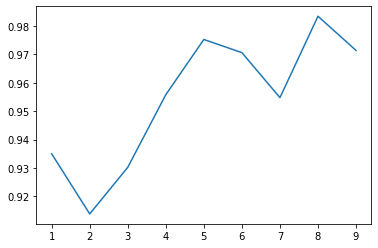

In [15]:
rvae_auc_scores = []
num_classes_trained = [1, 2, 3, 4, 5, 6, 7, 8, 9]
rvae = rVAE((28, 28), latent_dim=100, coord=1, seed=0)
trainer = SVItrainer(rvae)

trainer.load_model(rvae, 'saved_models/rvae_rotation_z_100_label_0.pkl')
score = pair_matching([1, 2, 3, 4, 5, 6, 7, 8, 9], rvae)
rvae_auc_scores.append(score)

trainer.load_model(rvae, 'saved_models/rvae_rotation_z_100_label_01.pkl')
score = pair_matching([2, 3, 4, 5, 6, 7, 8, 9], rvae)
rvae_auc_scores.append(score)

trainer.load_model(rvae, 'saved_models/rvae_rotation_z_100_label_012.pkl')
score = pair_matching([3, 4, 5, 6, 7, 8, 9], rvae)
rvae_auc_scores.append(score)

trainer.load_model(rvae, 'saved_models/rvae_rotation_z_100_label_0123.pkl')
score = pair_matching([4, 5, 6, 7, 8, 9], rvae)
rvae_auc_scores.append(score)

trainer.load_model(rvae, 'saved_models/rvae_rotation_z_100_label_01234.pkl')
score = pair_matching([5, 6, 7, 8, 9], rvae)
rvae_auc_scores.append(score)

trainer.load_model(rvae, 'saved_models/rvae_rotation_z_100_label_012345.pkl')
score = pair_matching([6, 7, 8, 9], rvae)
rvae_auc_scores.append(score)

trainer.load_model(rvae, 'saved_models/rvae_rotation_z_100_label_0123456.pkl')
score = pair_matching([7, 8, 9], rvae)
rvae_auc_scores.append(score)

trainer.load_model(rvae, 'saved_models/rvae_rotation_z_100_label_01234567.pkl')
score = pair_matching([8, 9], rvae)
rvae_auc_scores.append(score)

trainer.load_model(rvae, 'saved_models/rvae_rotation_z_100_label_012345678.pkl')
score = pair_matching([9], rvae)
rvae_auc_scores.append(score)

plt.plot(num_classes_trained, rvae_auc_scores)

/state/partition1/slurm_tmp/21252768.0.0/ipykernel_26197/3643694743.py:11: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  im = im.rotate(theta.item(), resample=Image.BICUBIC)
/state/partition1/slurm_tmp/21252768.0.0/ipykernel_26197/3643694743.py:11: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  im = im.rotate(theta.item(), resample=Image.BICUBIC)
/state/partition1/slurm_tmp/21252768.0.0/ipykernel_26197/3643694743.py:11: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  im = im.rotate(theta.item(), resample=Image.BICUBIC)
/state/partition1/slurm_tmp/21252768.0.0/ipykernel_26197/3643694743.py:11: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  im = im.rotate(theta.item(), resample=Image.BICUB

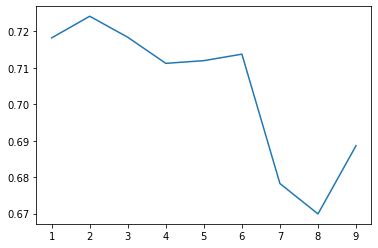

In [17]:
vae_auc_scores = []
num_classes_trained = [1, 2, 3, 4, 5, 6, 7, 8, 9]
vae = rVAE((28, 28), latent_dim=100, coord=0, seed=0)
trainer = SVItrainer(vae)

trainer.load_model(vae, 'saved_models/vae_rotation_z_100_label_0.pkl')
score = pair_matching([1, 2, 3, 4, 5, 6, 7, 8, 9], vae)
vae_auc_scores.append(score)

trainer.load_model(vae, 'saved_models/vae_rotation_z_100_label_01.pkl')
score = pair_matching([2, 3, 4, 5, 6, 7, 8, 9], vae)
vae_auc_scores.append(score)

trainer.load_model(vae, 'saved_models/vae_rotation_z_100_label_012.pkl')
score = pair_matching([3, 4, 5, 6, 7, 8, 9], vae)
vae_auc_scores.append(score)

trainer.load_model(vae, 'saved_models/vae_rotation_z_100_label_0123.pkl')
score = pair_matching([4, 5, 6, 7, 8, 9], vae)
vae_auc_scores.append(score)

trainer.load_model(vae, 'saved_models/vae_rotation_z_100_label_01234.pkl')
score = pair_matching([5, 6, 7, 8, 9], vae)
vae_auc_scores.append(score)

trainer.load_model(vae, 'saved_models/vae_rotation_z_100_label_012345.pkl')
score = pair_matching([6, 7, 8, 9], vae)
vae_auc_scores.append(score)

trainer.load_model(vae, 'saved_models/vae_rotation_z_100_label_0123456.pkl')
score = pair_matching([7, 8, 9], vae)
vae_auc_scores.append(score)

trainer.load_model(vae, 'saved_models/vae_rotation_z_100_label_01234567.pkl')
score = pair_matching([8, 9], vae)
vae_auc_scores.append(score)

trainer.load_model(vae, 'saved_models/vae_rotation_z_100_label_012345678.pkl')
score = pair_matching([9], vae)
vae_auc_scores.append(score)

plt.plot(num_classes_trained, vae_auc_scores)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


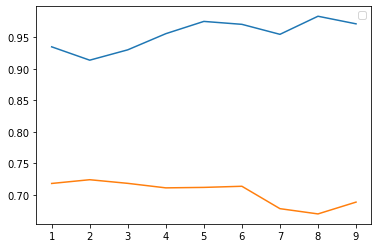

In [18]:
plt.plot(num_classes_trained, rave_auc_scores)
plt.plot(num_classes_trained, vae_auc_scores)
plt.legend()

/state/partition1/slurm_tmp/21252768.0.0/ipykernel_26197/3643694743.py:11: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  im = im.rotate(theta.item(), resample=Image.BICUBIC)


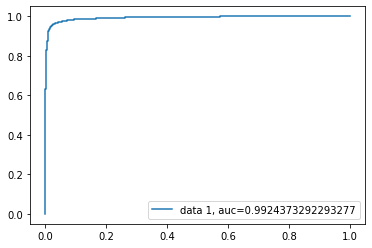

In [19]:
#pair of corresponding rotated image
test_data1, test_labels1, test_angles1 = get_mnist_data(mnist_testset, digits = [0,1,2,3,4], n_samples = None, rotation_range=[-60, 61], rotate = False)
test_data2, test_labels2, test_angles2 = get_mnist_data(mnist_testset, digits = [0,1,2,3,4], n_samples = None, rotation_range=[-60, 61], rotate = True)
idx = torch.arange(test_labels2.size()[0])
same_label = torch.ones((test_labels1.size()[0]))

#shuffled pairs
indices = torch.randperm(test_labels2.size()[0])
test_data2_shuffled = test_data2[indices]
test_labels2_shuffled = test_labels2[indices]
same_label_shuffled = (indices==idx).long()

# we are only interested in checking if a pair of two images(rotated and non-rotated) are same or not (irrespective of label)
point1 = torch.cat([test_data1, test_data1])
point2 = torch.cat([test_data2, test_data2_shuffled])
label = torch.cat([same_label, same_label_shuffled])

z1 = rvae.encode(point1)
z_mu1, z_sigma1 = z1[0], z1[1]
z_sample1 = z_mu1 + torch.randn_like(z_mu1)*z_sigma1

z2 = rvae.encode(point2)
z_mu2, z_sigma2 = z2[0], z2[1]
z_sample2 = z_mu2 + torch.randn_like(z_mu2)*z_sigma2

point1 = z_mu1[:, 1:]
point2 = z_mu2[:, 1:]

import matplotlib.pyplot as plt
cos = torch.nn.CosineSimilarity(dim=1)
scores = cos(point1, point2)
fpr, tpr, thresholds = roc_curve(label, scores, pos_label=1)
# plot_roc_curve(label, scores)
auc = roc_auc_score(label, scores)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()
plt.show()

/state/partition1/slurm_tmp/21245250.0.0/ipykernel_68080/3643694743.py:11: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  im = im.rotate(theta.item(), resample=Image.BICUBIC)


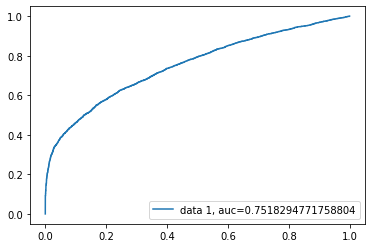

In [43]:
#pair of corresponding rotated image
test_data1, test_labels1, test_angles1 = get_mnist_data(mnist_testset, digits = [0,1,2,3,4], n_samples = None, rotation_range=[-60, 61], rotate = False)
test_data2, test_labels2, test_angles2 = get_mnist_data(mnist_testset, digits = [0,1,2,3,4], n_samples = None, rotation_range=[-60, 61], rotate = True)
idx = torch.arange(test_labels2.size()[0])
same_label = torch.ones((test_labels1.size()[0]))

#shuffled pairs
indices = torch.randperm(test_labels2.size()[0])
test_data2_shuffled = test_data2[indices]
test_labels2_shuffled = test_labels2[indices]
same_label_shuffled = (indices==idx).long()

# we are only interested in checking if a pair of two images(rotated and non-rotated) are same or not (irrespective of label)
point1 = torch.cat([test_data1, test_data1])
point2 = torch.cat([test_data2, test_data2_shuffled])
label = torch.cat([same_label, same_label_shuffled])

z1 = vae.encode(point1)
z_mu1, z_sigma1 = z1[0], z1[1]
z_sample1 = z_mu1 + torch.randn_like(z_mu1)*z_sigma1

z2 = vae.encode(point2)
z_mu2, z_sigma2 = z2[0], z2[1]
z_sample2 = z_mu2 + torch.randn_like(z_mu2)*z_sigma2

point1 = z_mu1[:, 1:]
point2 = z_mu2[:, 1:]

import matplotlib.pyplot as plt
cos = torch.nn.CosineSimilarity(dim=1)
scores = cos(point1, point2)
fpr, tpr, thresholds = roc_curve(label, scores, pos_label=1)
# plot_roc_curve(label, scores)
auc = roc_auc_score(label, scores)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()
plt.show()

## classification

/state/partition1/slurm_tmp/21245250.0.0/ipykernel_68080/3643694743.py:11: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  im = im.rotate(theta.item(), resample=Image.BICUBIC)


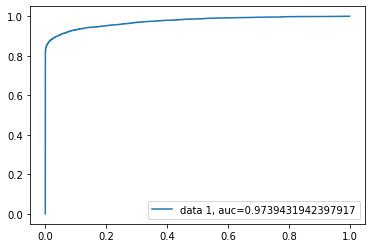

In [23]:
#pair of corresponding rotated image
test_data1, test_labels1, test_angles1 = get_mnist_data(mnist_testset, digits = [0,1,2,3,4], n_samples = None, rotation_range=[-60, 61], rotate = False)
test_data2, test_labels2, test_angles2 = get_mnist_data(mnist_testset, digits = [0,1,2,3,4], n_samples = None, rotation_range=[-60, 61], rotate = True)
idx = torch.arange(test_labels2.size()[0])
same_label = torch.ones((test_labels1.size()[0]))

#shuffled pairs
indices = torch.randperm(test_labels2.size()[0])
test_data2_shuffled = test_data2[indices]
test_labels2_shuffled = test_labels2[indices]
same_label_shuffled = (test_labels2_shuffled==test_labels2).long()

# we are only interested in checking if a pair of two images(rotated and non-rotated) are same or not (for same class label-> should be same)
point1 = torch.cat([test_data1, test_data1])
point2 = torch.cat([test_data2, test_data2_shuffled])
label = torch.cat([same_label, same_label_shuffled])

z1 = rvae.encode(point1)
z_mu1, z_sigma1 = z1[0], z1[1]
z_sample1 = z_mu1 + torch.randn_like(z_mu1)*z_sigma1

z2 = rvae.encode(point2)
z_mu2, z_sigma2 = z2[0], z2[1]
z_sample2 = z_mu2 + torch.randn_like(z_mu2)*z_sigma2

point1 = z_mu1[:, 1:]
point2 = z_mu2[:, 1:]

import matplotlib.pyplot as plt
cos = torch.nn.CosineSimilarity(dim=1)
scores = cos(point1, point2)
fpr, tpr, thresholds = roc_curve(label, scores, pos_label=1)
# plot_roc_curve(label, scores)
auc = roc_auc_score(label, scores)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()
plt.show()

/state/partition1/slurm_tmp/21245250.0.0/ipykernel_68080/3643694743.py:11: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  im = im.rotate(theta.item(), resample=Image.BICUBIC)


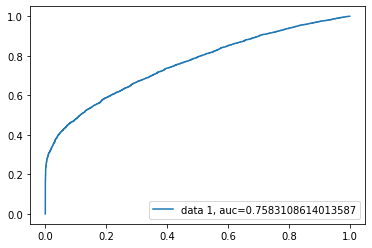

In [44]:
#pair of corresponding rotated image
test_data1, test_labels1, test_angles1 = get_mnist_data(mnist_testset, digits = [0,1,2,3,4], n_samples = None, rotation_range=[-60, 61], rotate = False)
test_data2, test_labels2, test_angles2 = get_mnist_data(mnist_testset, digits = [0,1,2,3,4], n_samples = None, rotation_range=[-60, 61], rotate = True)
idx = torch.arange(test_labels2.size()[0])
same_label = torch.ones((test_labels1.size()[0]))

#shuffled pairs
indices = torch.randperm(test_labels2.size()[0])
test_data2_shuffled = test_data2[indices]
test_labels2_shuffled = test_labels2[indices]
same_label_shuffled = (test_labels2_shuffled==test_labels2).long()

# we are only interested in checking if a pair of two images(rotated and non-rotated) are same or not (for same class label-> should be same)
point1 = torch.cat([test_data1, test_data1])
point2 = torch.cat([test_data2, test_data2_shuffled])
label = torch.cat([same_label, same_label_shuffled])

z1 = vae.encode(point1)
z_mu1, z_sigma1 = z1[0], z1[1]
z_sample1 = z_mu1 + torch.randn_like(z_mu1)*z_sigma1

z2 = vae.encode(point2)
z_mu2, z_sigma2 = z2[0], z2[1]
z_sample2 = z_mu2 + torch.randn_like(z_mu2)*z_sigma2

point1 = z_mu1[:, 1:]
point2 = z_mu2[:, 1:]

import matplotlib.pyplot as plt
cos = torch.nn.CosineSimilarity(dim=1)
scores = cos(point1, point2)
fpr, tpr, thresholds = roc_curve(label, scores, pos_label=1)
# plot_roc_curve(label, scores)
auc = roc_auc_score(label, scores)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()
plt.show()

In [26]:
thresholds

array([ 2.0000002,  1.0000002,  1.0000001, ..., -0.7946775, -0.7974895,
       -0.9147204], dtype=float32)

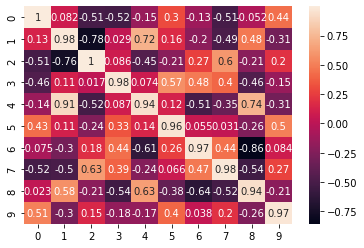

In [31]:
z1 = rvae.encode(test_data1[:10])
z_mu1, z_sigma1 = z1[0], z1[1]
z_sample1 = z_mu1 + torch.randn_like(z_mu1)*z_sigma1

z2 = rvae.encode(test_data2[:10])
z_mu2, z_sigma2 = z2[0], z2[1]
z_sample2 = z_mu2 + torch.randn_like(z_mu2)*z_sigma2

point1 = z_mu1[:, 1:]
point2 = z_mu2[:, 1:]

from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sn
scores = cosine_similarity(point1, point2)
heatmap = sn.heatmap(scores, annot=True)
fig = heatmap.get_figure()
# fig.savefig("heatmap.svg") 

In [8]:
test_data1, test_labels1, test_angles1 = get_mnist_data(mnist_testset, digits = [5,6,7,8,9], n_samples = None, rotation_range=[-60, 61], rotate = False)
test_data2, test_labels2, test_angles2 = get_mnist_data(mnist_testset, digits = [5,6,7,8,9], n_samples = None, rotation_range=[-60, 61], rotate = True)


In [ ]:
z1 = rvae.encode(test_data1[:10])
z_mu1, z_sigma1 = z1[0], z1[1]
z_sample1 = z_mu1 + torch.randn_like(z_mu1)*z_sigma1

z2 = rvae.encode(test_data2[:10])
z_mu2, z_sigma2 = z2[0], z2[1]
z_sample2 = z_mu2 + torch.randn_like(z_mu2)*z_sigma2

point1 = z_mu1[:, 1:]
point2 = z_mu2[:, 1:]

from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sn
scores = cosine_similarity(point1, point2)
heatmap = sn.heatmap(scores, annot=True)
fig = heatmap.get_figure()
fig.savefig("heatmap.svg") 

/state/partition1/slurm_tmp/21245250.0.0/ipykernel_68080/3643694743.py:11: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  im = im.rotate(theta.item(), resample=Image.BICUBIC)


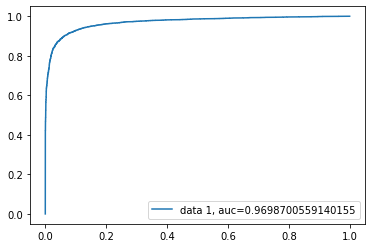

In [32]:
#pair of corresponding rotated image
test_data1, test_labels1, test_angles1 = get_mnist_data(mnist_testset, digits = [5,6,7,8,9], n_samples = None, rotation_range=[-60, 61], rotate = False)
test_data2, test_labels2, test_angles2 = get_mnist_data(mnist_testset, digits = [5,6,7,8,9], n_samples = None, rotation_range=[-60, 61], rotate = True)
idx = torch.arange(test_labels2.size()[0])
same_label = torch.ones((test_labels1.size()[0]))

#shuffled pairs
indices = torch.randperm(test_labels2.size()[0])
test_data2_shuffled = test_data2[indices]
test_labels2_shuffled = test_labels2[indices]
same_label_shuffled = (indices==idx).long()

# we are only interested in checking if a pair of two images(rotated and non-rotated) are same or not (irrespective of label)
point1 = torch.cat([test_data1, test_data1])
point2 = torch.cat([test_data2, test_data2_shuffled])
label = torch.cat([same_label, same_label_shuffled])

z1 = rvae.encode(point1)
z_mu1, z_sigma1 = z1[0], z1[1]
z_sample1 = z_mu1 + torch.randn_like(z_mu1)*z_sigma1

z2 = rvae.encode(point2)
z_mu2, z_sigma2 = z2[0], z2[1]
z_sample2 = z_mu2 + torch.randn_like(z_mu2)*z_sigma2

point1 = z_mu1[:, 1:]
point2 = z_mu2[:, 1:]

import matplotlib.pyplot as plt
cos = torch.nn.CosineSimilarity(dim=1)
scores = cos(point1, point2)
fpr, tpr, thresholds = roc_curve(label, scores, pos_label=1)
# plot_roc_curve(label, scores)
auc = roc_auc_score(label, scores)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()
plt.show()

/state/partition1/slurm_tmp/21245250.0.0/ipykernel_68080/3643694743.py:11: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  im = im.rotate(theta.item(), resample=Image.BICUBIC)


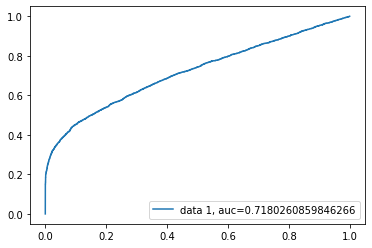

In [45]:
#pair of corresponding rotated image
test_data1, test_labels1, test_angles1 = get_mnist_data(mnist_testset, digits = [5,6,7,8,9], n_samples = None, rotation_range=[-60, 61], rotate = False)
test_data2, test_labels2, test_angles2 = get_mnist_data(mnist_testset, digits = [5,6,7,8,9], n_samples = None, rotation_range=[-60, 61], rotate = True)
idx = torch.arange(test_labels2.size()[0])
same_label = torch.ones((test_labels1.size()[0]))

#shuffled pairs
indices = torch.randperm(test_labels2.size()[0])
test_data2_shuffled = test_data2[indices]
test_labels2_shuffled = test_labels2[indices]
same_label_shuffled = (indices==idx).long()

# we are only interested in checking if a pair of two images(rotated and non-rotated) are same or not (irrespective of label)
point1 = torch.cat([test_data1, test_data1])
point2 = torch.cat([test_data2, test_data2_shuffled])
label = torch.cat([same_label, same_label_shuffled])

z1 = vae.encode(point1)
z_mu1, z_sigma1 = z1[0], z1[1]
z_sample1 = z_mu1 + torch.randn_like(z_mu1)*z_sigma1

z2 = vae.encode(point2)
z_mu2, z_sigma2 = z2[0], z2[1]
z_sample2 = z_mu2 + torch.randn_like(z_mu2)*z_sigma2

point1 = z_mu1[:, 1:]
point2 = z_mu2[:, 1:]

import matplotlib.pyplot as plt
cos = torch.nn.CosineSimilarity(dim=1)
scores = cos(point1, point2)
fpr, tpr, thresholds = roc_curve(label, scores, pos_label=1)
# plot_roc_curve(label, scores)
auc = roc_auc_score(label, scores)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()
plt.show()

/state/partition1/slurm_tmp/21245250.0.0/ipykernel_68080/3643694743.py:11: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  im = im.rotate(theta.item(), resample=Image.BICUBIC)


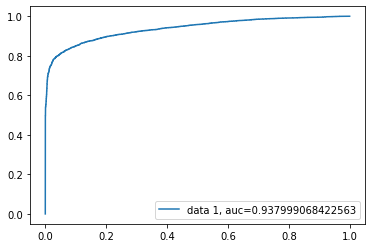

In [33]:
#pair of corresponding rotated image
test_data1, test_labels1, test_angles1 = get_mnist_data(mnist_testset, digits = [5,6,7,8,9], n_samples = None, rotation_range=[-60, 61], rotate = False)
test_data2, test_labels2, test_angles2 = get_mnist_data(mnist_testset, digits = [5,6,7,8,9], n_samples = None, rotation_range=[-60, 61], rotate = True)
idx = torch.arange(test_labels2.size()[0])
same_label = torch.ones((test_labels1.size()[0]))

#shuffled pairs
indices = torch.randperm(test_labels2.size()[0])
test_data2_shuffled = test_data2[indices]
test_labels2_shuffled = test_labels2[indices]
same_label_shuffled = (test_labels2_shuffled==test_labels2).long()

# we are only interested in checking if a pair of two images(rotated and non-rotated) are same or not (for same class label-> should be same)
point1 = torch.cat([test_data1, test_data1])
point2 = torch.cat([test_data2, test_data2_shuffled])
label = torch.cat([same_label, same_label_shuffled])

z1 = rvae.encode(point1)
z_mu1, z_sigma1 = z1[0], z1[1]
z_sample1 = z_mu1 + torch.randn_like(z_mu1)*z_sigma1

z2 = rvae.encode(point2)
z_mu2, z_sigma2 = z2[0], z2[1]
z_sample2 = z_mu2 + torch.randn_like(z_mu2)*z_sigma2

point1 = z_mu1[:, 1:]
point2 = z_mu2[:, 1:]

import matplotlib.pyplot as plt
cos = torch.nn.CosineSimilarity(dim=1)
scores = cos(point1, point2)
fpr, tpr, thresholds = roc_curve(label, scores, pos_label=1)
# plot_roc_curve(label, scores)
auc = roc_auc_score(label, scores)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()
plt.show()

/state/partition1/slurm_tmp/21245250.0.0/ipykernel_68080/3643694743.py:11: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  im = im.rotate(theta.item(), resample=Image.BICUBIC)


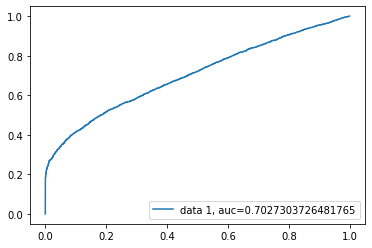

In [46]:
#pair of corresponding rotated image
test_data1, test_labels1, test_angles1 = get_mnist_data(mnist_testset, digits = [5,6,7,8,9], n_samples = None, rotation_range=[-60, 61], rotate = False)
test_data2, test_labels2, test_angles2 = get_mnist_data(mnist_testset, digits = [5,6,7,8,9], n_samples = None, rotation_range=[-60, 61], rotate = True)
idx = torch.arange(test_labels2.size()[0])
same_label = torch.ones((test_labels1.size()[0]))

#shuffled pairs
indices = torch.randperm(test_labels2.size()[0])
test_data2_shuffled = test_data2[indices]
test_labels2_shuffled = test_labels2[indices]
same_label_shuffled = (test_labels2_shuffled==test_labels2).long()

# we are only interested in checking if a pair of two images(rotated and non-rotated) are same or not (for same class label-> should be same)
point1 = torch.cat([test_data1, test_data1])
point2 = torch.cat([test_data2, test_data2_shuffled])
label = torch.cat([same_label, same_label_shuffled])

z1 = vae.encode(point1)
z_mu1, z_sigma1 = z1[0], z1[1]
z_sample1 = z_mu1 + torch.randn_like(z_mu1)*z_sigma1

z2 = vae.encode(point2)
z_mu2, z_sigma2 = z2[0], z2[1]
z_sample2 = z_mu2 + torch.randn_like(z_mu2)*z_sigma2

point1 = z_mu1[:, 1:]
point2 = z_mu2[:, 1:]

import matplotlib.pyplot as plt
cos = torch.nn.CosineSimilarity(dim=1)
scores = cos(point1, point2)
fpr, tpr, thresholds = roc_curve(label, scores, pos_label=1)
# plot_roc_curve(label, scores)
auc = roc_auc_score(label, scores)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()
plt.show()

In [ ]:
z1 = rvae.encode(test_data1[:10])
z_mu1, z_sigma1 = z1[0], z1[1]
z_sample1 = z_mu1 + torch.randn_like(z_mu1)*z_sigma1

z2 = rvae.encode(test_data2[:10])
z_mu2, z_sigma2 = z2[0], z2[1]
z_sample2 = z_mu2 + torch.randn_like(z_mu2)*z_sigma2

point1 = z_mu1[:, 1:]
point2 = z_mu2[:, 1:]

from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sn
scores = cosine_similarity(point1, point2)
heatmap = sn.heatmap(scores, annot=True)
fig = heatmap.get_figure()
# fig.savefig("heatmap.svg") 

## fashionMNIST

In [34]:
fashionmnist_trainset = datasets.FashionMNIST('data/FashionMNIST/', train=True, download=True)
fashionmnist_testset = datasets.FashionMNIST('data/FashionMNIST/', train=False, download=True)

/state/partition1/slurm_tmp/21245250.0.0/ipykernel_68080/3643694743.py:11: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  im = im.rotate(theta.item(), resample=Image.BICUBIC)


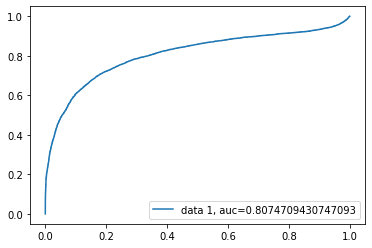

In [37]:
#pair of corresponding rotated image
test_data1, test_labels1, test_angles1 = get_mnist_data(fashionmnist_testset, digits = [0,1,2,3,4,5,6,7,8,9], n_samples = None, rotation_range=[-60, 61], rotate = False)
test_data2, test_labels2, test_angles2 = get_mnist_data(fashionmnist_testset, digits = [0,1,2,3,4,5,6,7,8,9], n_samples = None, rotation_range=[-60, 61], rotate = True)
idx = torch.arange(test_labels2.size()[0])
same_label = torch.ones((test_labels1.size()[0]))

#shuffled pairs
indices = torch.randperm(test_labels2.size()[0])
test_data2_shuffled = test_data2[indices]
test_labels2_shuffled = test_labels2[indices]
same_label_shuffled = (indices==idx).long()

# we are only interested in checking if a pair of two images(rotated and non-rotated) are same or not (irrespective of label)
point1 = torch.cat([test_data1, test_data1])
point2 = torch.cat([test_data2, test_data2_shuffled])
label = torch.cat([same_label, same_label_shuffled])

z1 = rvae.encode(point1)
z_mu1, z_sigma1 = z1[0], z1[1]
z_sample1 = z_mu1 + torch.randn_like(z_mu1)*z_sigma1

z2 = rvae.encode(point2)
z_mu2, z_sigma2 = z2[0], z2[1]
z_sample2 = z_mu2 + torch.randn_like(z_mu2)*z_sigma2

point1 = z_mu1[:, 1:]
point2 = z_mu2[:, 1:]

import matplotlib.pyplot as plt
cos = torch.nn.CosineSimilarity(dim=1)
scores = cos(point1, point2)
fpr, tpr, thresholds = roc_curve(label, scores, pos_label=1)
# plot_roc_curve(label, scores)
auc = roc_auc_score(label, scores)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()
plt.show()

/state/partition1/slurm_tmp/21245250.0.0/ipykernel_68080/3643694743.py:11: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  im = im.rotate(theta.item(), resample=Image.BICUBIC)


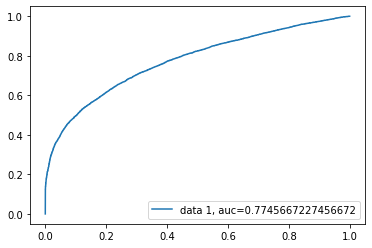

In [48]:
#pair of corresponding rotated image
test_data1, test_labels1, test_angles1 = get_mnist_data(fashionmnist_testset, digits = [0,1,2,3,4,5,6,7,8,9], n_samples = None, rotation_range=[-60, 61], rotate = False)
test_data2, test_labels2, test_angles2 = get_mnist_data(fashionmnist_testset, digits = [0,1,2,3,4,5,6,7,8,9], n_samples = None, rotation_range=[-60, 61], rotate = True)
idx = torch.arange(test_labels2.size()[0])
same_label = torch.ones((test_labels1.size()[0]))

#shuffled pairs
indices = torch.randperm(test_labels2.size()[0])
test_data2_shuffled = test_data2[indices]
test_labels2_shuffled = test_labels2[indices]
same_label_shuffled = (indices==idx).long()

# we are only interested in checking if a pair of two images(rotated and non-rotated) are same or not (irrespective of label)
point1 = torch.cat([test_data1, test_data1])
point2 = torch.cat([test_data2, test_data2_shuffled])
label = torch.cat([same_label, same_label_shuffled])

z1 = vae.encode(point1)
z_mu1, z_sigma1 = z1[0], z1[1]
z_sample1 = z_mu1 + torch.randn_like(z_mu1)*z_sigma1

z2 = vae.encode(point2)
z_mu2, z_sigma2 = z2[0], z2[1]
z_sample2 = z_mu2 + torch.randn_like(z_mu2)*z_sigma2

point1 = z_mu1[:, 1:]
point2 = z_mu2[:, 1:]

import matplotlib.pyplot as plt
cos = torch.nn.CosineSimilarity(dim=1)
scores = cos(point1, point2)
fpr, tpr, thresholds = roc_curve(label, scores, pos_label=1)
# plot_roc_curve(label, scores)
auc = roc_auc_score(label, scores)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()
plt.show()

/state/partition1/slurm_tmp/21245250.0.0/ipykernel_68080/3643694743.py:11: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  im = im.rotate(theta.item(), resample=Image.BICUBIC)


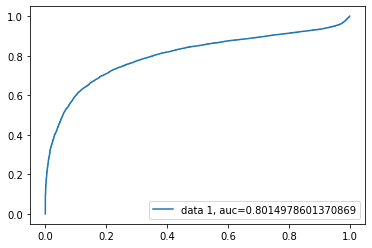

In [38]:
#pair of corresponding rotated image
test_data1, test_labels1, test_angles1 = get_mnist_data(fashionmnist_testset, digits = [0,1,2,3,4,5,6,7,8,9], n_samples = None, rotation_range=[-60, 61], rotate = False)
test_data2, test_labels2, test_angles2 = get_mnist_data(fashionmnist_testset, digits = [0,1,2,3,4,5,6,7,8,9], n_samples = None, rotation_range=[-60, 61], rotate = True)
idx = torch.arange(test_labels2.size()[0])
same_label = torch.ones((test_labels1.size()[0]))

#shuffled pairs
indices = torch.randperm(test_labels2.size()[0])
test_data2_shuffled = test_data2[indices]
test_labels2_shuffled = test_labels2[indices]
same_label_shuffled = (test_labels2_shuffled==test_labels2).long()

# we are only interested in checking if a pair of two images(rotated and non-rotated) are same or not (for same class label-> should be same)
point1 = torch.cat([test_data1, test_data1])
point2 = torch.cat([test_data2, test_data2_shuffled])
label = torch.cat([same_label, same_label_shuffled])

z1 = rvae.encode(point1)
z_mu1, z_sigma1 = z1[0], z1[1]
z_sample1 = z_mu1 + torch.randn_like(z_mu1)*z_sigma1

z2 = rvae.encode(point2)
z_mu2, z_sigma2 = z2[0], z2[1]
z_sample2 = z_mu2 + torch.randn_like(z_mu2)*z_sigma2

point1 = z_mu1[:, 1:]
point2 = z_mu2[:, 1:]

import matplotlib.pyplot as plt
cos = torch.nn.CosineSimilarity(dim=1)
scores = cos(point1, point2)
fpr, tpr, thresholds = roc_curve(label, scores, pos_label=1)
# plot_roc_curve(label, scores)
auc = roc_auc_score(label, scores)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()
plt.show()

/state/partition1/slurm_tmp/21245250.0.0/ipykernel_68080/3643694743.py:11: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  im = im.rotate(theta.item(), resample=Image.BICUBIC)


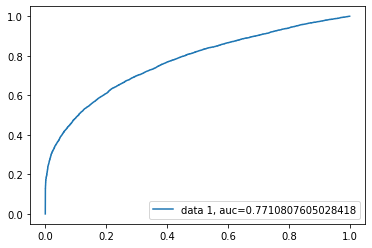

In [49]:
#pair of corresponding rotated image
test_data1, test_labels1, test_angles1 = get_mnist_data(fashionmnist_testset, digits = [0,1,2,3,4,5,6,7,8,9], n_samples = None, rotation_range=[-60, 61], rotate = False)
test_data2, test_labels2, test_angles2 = get_mnist_data(fashionmnist_testset, digits = [0,1,2,3,4,5,6,7,8,9], n_samples = None, rotation_range=[-60, 61], rotate = True)
idx = torch.arange(test_labels2.size()[0])
same_label = torch.ones((test_labels1.size()[0]))

#shuffled pairs
indices = torch.randperm(test_labels2.size()[0])
test_data2_shuffled = test_data2[indices]
test_labels2_shuffled = test_labels2[indices]
same_label_shuffled = (test_labels2_shuffled==test_labels2).long()

# we are only interested in checking if a pair of two images(rotated and non-rotated) are same or not (for same class label-> should be same)
point1 = torch.cat([test_data1, test_data1])
point2 = torch.cat([test_data2, test_data2_shuffled])
label = torch.cat([same_label, same_label_shuffled])

z1 = vae.encode(point1)
z_mu1, z_sigma1 = z1[0], z1[1]
z_sample1 = z_mu1 + torch.randn_like(z_mu1)*z_sigma1

z2 = vae.encode(point2)
z_mu2, z_sigma2 = z2[0], z2[1]
z_sample2 = z_mu2 + torch.randn_like(z_mu2)*z_sigma2

point1 = z_mu1[:, 1:]
point2 = z_mu2[:, 1:]

import matplotlib.pyplot as plt
cos = torch.nn.CosineSimilarity(dim=1)
scores = cos(point1, point2)
fpr, tpr, thresholds = roc_curve(label, scores, pos_label=1)
# plot_roc_curve(label, scores)
auc = roc_auc_score(label, scores)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()
plt.show()